# DMDc

In [18]:
# glycoSMC/koopman/data_loader.py

import os
import pandas as pd
import numpy as np

def load_data(data_dir='../data/', fill_nans=True):
    """
    Load and concatenate all CSV files from the specified directory.

    Parameters
    ----------
    data_dir : str, optional
        Path to the data directory (default is '../data/').
    fill_nans : bool, optional
        If True, forward‑fill and backward‑fill any remaining NaNs in
        BG, insulin, and meal columns. If False, raise an error when NaNs
        are encountered.

    Returns
    -------
    dict
        Dictionary containing numpy arrays:
        - BG: blood glucose values (mg/dL)
        - insulin: insulin delivered (U)
        - meal: carbohydrate intake (g)
        - t_minutes: time in minutes
        - patient: patient identifier (as strings)
    """
    # Resolve absolute path to avoid working directory issues
    base_path = os.path.abspath(data_dir)
    if not os.path.isdir(base_path):
        raise FileNotFoundError(f"Data directory not found: {base_path}")

    csv_files = [f for f in os.listdir(base_path) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base_path}")

    df_list = []
    for file in csv_files:
        file_path = os.path.join(base_path, file)
        df = pd.read_csv(file_path, parse_dates=['time'])
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    # Sort by patient and time to ensure chronological order
    df_all.sort_values(['patient', 'time'], inplace=True)
    df_all.reset_index(drop=True, inplace=True)

    # Check for missing values in essential columns
    essential_cols = ['BG', 'insulin', 'meal']
    if df_all[essential_cols].isnull().any().any():
        if fill_nans:
            print("Warning: Missing values detected. Applying forward‑fill then backward‑fill.")
            # Forward fill within each patient group to avoid mixing patients
            # Use ffill() and bfill() (method='ffill' is deprecated)
            df_all[essential_cols] = df_all.groupby('patient')[essential_cols].transform(
                lambda group: group.ffill().bfill()
            )
            # If still any NaNs (e.g., all NaN for a patient), raise error
            if df_all[essential_cols].isnull().any().any():
                raise ValueError("Unable to fill all NaNs. Please check the data.")
        else:
            raise ValueError("Input data contains NaNs. Set fill_nans=True or clean the data.")

    # Extract required columns as numpy arrays
    BG = df_all['BG'].values.astype(np.float64)
    insulin = df_all['insulin'].values.astype(np.float64)
    meal = df_all['meal'].values.astype(np.float64)
    t_minutes = df_all['t_minutes'].values.astype(np.float64)
    patient = df_all['patient'].values.astype(str)

    # Basic sanity check: sampling interval should be 3 minutes
    diffs = np.diff(t_minutes)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, 3):
        print(f"Warning: Sampling interval not uniformly 3 minutes. Found: {unique_diffs}")

    return {
        'BG': BG,
        'insulin': insulin,
        'meal': meal,
        't_minutes': t_minutes,
        'patient': patient
    }

In [19]:
# glycoSMC/koopman/embedding.py

import numpy as np

def build_embedding(BG, insulin, meal, g_delays=4, ins_delays=2, meal_delays=2):
    """
    Construct delay‑embedded lifted states for DMDc.

    The lifted state at time index k is:
        z_k = [g_k, g_{k-1}, g_{k-2}, g_{k-3},
               u_ins_k, u_ins_{k-1},
               u_meal_k, u_meal_{k-1}]^T   (size = g_delays + ins_delays + meal_delays)

    The control input at time k is:
        u_k = [insulin_k, meal_k]^T

    Parameters
    ----------
    BG : np.ndarray, shape (T,)
        Blood glucose time series.
    insulin : np.ndarray, shape (T,)
        Insulin delivery time series.
    meal : np.ndarray, shape (T,)
        Meal intake time series.
    g_delays : int, optional
        Number of glucose delays (including current) (default 4).
    ins_delays : int, optional
        Number of insulin delays to include in state (current and past) (default 2).
    meal_delays : int, optional
        Number of meal delays to include in state (current and past) (default 2).

    Returns
    -------
    Z : np.ndarray, shape (state_dim, N)
        Matrix of lifted states (columns are z_k for k = start_idx ... end_idx).
    Z_next : np.ndarray, shape (state_dim, N)
        Matrix of one‑step ahead lifted states (z_{k+1}).
    U : np.ndarray, shape (2, N)
        Matrix of control inputs (u_k).
    """
    # Check for NaNs or infinite values in input
    for arr, name in zip([BG, insulin, meal], ['BG', 'insulin', 'meal']):
        if not np.all(np.isfinite(arr)):
            raise ValueError(f"Input array '{name}' contains non‑finite values (NaN or inf).")

    T = len(BG)
    state_dim = g_delays + ins_delays + meal_delays  # should be 4+2+2 = 8

    # Indices required:
    # For z_k we need BG[k], BG[k-1], ..., BG[k-(g_delays-1)] → k >= g_delays-1
    # Also insulin[k], insulin[k-1], ..., insulin[k-(ins_delays-1)] → k >= ins_delays-1
    # Similarly meal delays → k >= meal_delays-1
    # The most restrictive is the maximum of these lower bounds.
    # Since we also need z_{k+1} (for Z_next), the highest k must be ≤ T-2.
    start_idx = max(g_delays - 1, ins_delays - 1, meal_delays - 1)  # = 3
    end_idx = T - 2  # inclusive, so that k+1 ≤ T-1
    if end_idx < start_idx:
        raise ValueError("Not enough data points for the requested delays.")

    N = end_idx - start_idx + 1
    Z = np.zeros((state_dim, N))
    Z_next = np.zeros((state_dim, N))
    U = np.zeros((2, N))

    for i, k in enumerate(range(start_idx, end_idx + 1)):
        # Current lifted state z_k
        Z[0, i] = BG[k]                     # g_k
        Z[1, i] = BG[k-1]                   # g_{k-1}
        Z[2, i] = BG[k-2]                   # g_{k-2}
        Z[3, i] = BG[k-3]                   # g_{k-3}
        Z[4, i] = insulin[k]                 # u_ins_k
        Z[5, i] = insulin[k-1]               # u_ins_{k-1}
        Z[6, i] = meal[k]                    # u_meal_k
        Z[7, i] = meal[k-1]                  # u_meal_{k-1}

        # Control input u_k
        U[0, i] = insulin[k]
        U[1, i] = meal[k]

        # Next lifted state z_{k+1}
        Z_next[0, i] = BG[k+1]               # g_{k+1}
        Z_next[1, i] = BG[k]                 # g_k
        Z_next[2, i] = BG[k-1]               # g_{k-1}
        Z_next[3, i] = BG[k-2]               # g_{k-2}
        Z_next[4, i] = insulin[k+1]           # u_ins_{k+1}
        Z_next[5, i] = insulin[k]             # u_ins_k
        Z_next[6, i] = meal[k+1]              # u_meal_{k+1}
        Z_next[7, i] = meal[k]                # u_meal_k

    return Z, Z_next, U

Loading data...
Total samples: 10083

Building delay embedding...
Lifted state dimension: 8
Number of snapshots: 10079

Training snapshots: 8063
Testing snapshots : 2016

Performing DMDc with full rank...


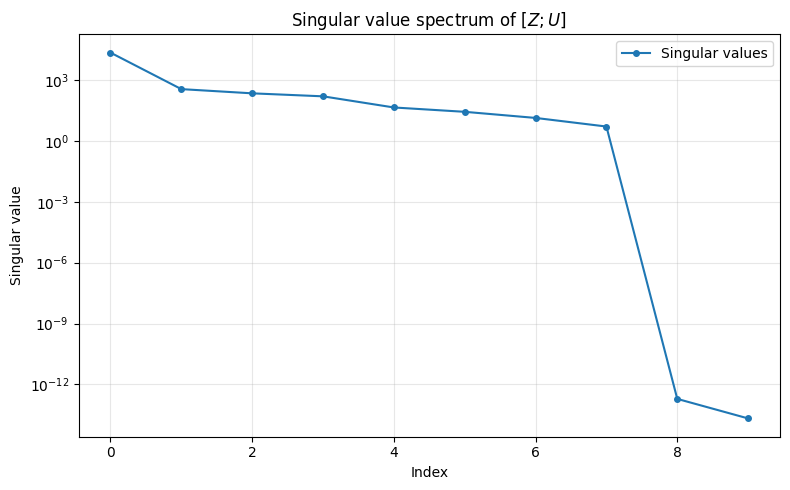


Cumulative energy explained:
  rank 3: 0.9999
  rank 4: 1.0000
  rank 5: 1.0000
  rank 6: 1.0000

Retraining with rank = 4


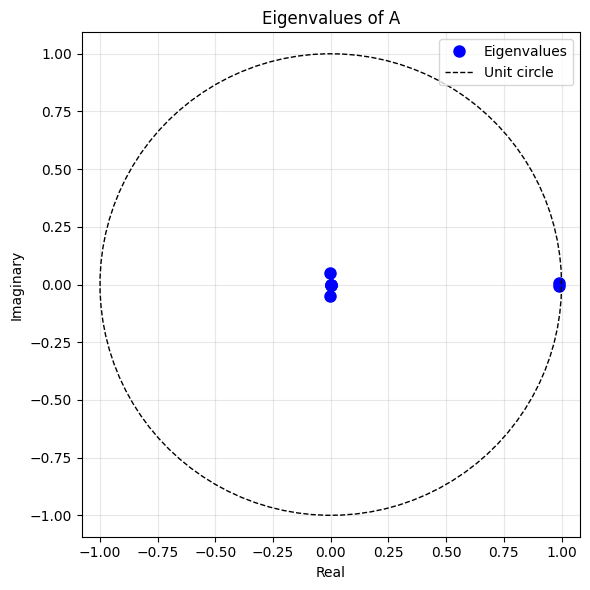


Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9883, τ=255.05 min
  Mode 2: |λ|=0.9883, τ=255.05 min
  Mode 3: |λ|=0.0497, τ=1.00 min
  Mode 4: |λ|=0.0497, τ=1.00 min
  Mode 5: |λ|=0.0000, τ=0.08 min
  Mode 6: |λ|=0.0000, τ=0.08 min
  Mode 7: |λ|=0.0000, τ=0.07 min
  Mode 8: |λ|=0.0000, τ=0.07 min

Prediction RMSE over 40 steps (120 min): 42.32 mg/dL


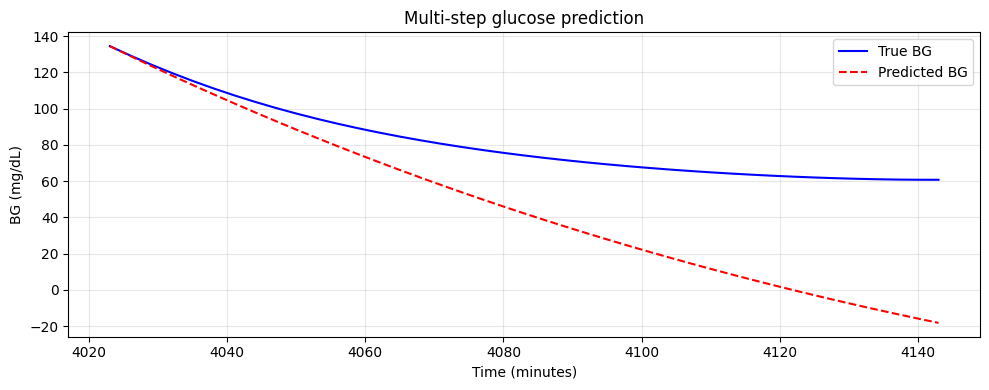


Training and evaluation complete.


In [20]:
# glycoSMC/koopman/train_dmdc.py

import os
import numpy as np
import matplotlib.pyplot as plt



def main():
    # -------------------- Data Loading --------------------
    data_dir = os.path.join('..', 'data')
    print("Loading data...")
    data = load_data(data_dir, fill_nans=True)  # fill any NaNs automatically
    BG = data['BG']
    insulin = data['insulin']
    meal = data['meal']
    t_minutes = data['t_minutes']
    print(f"Total samples: {len(BG)}")

    # -------------------- Embedding --------------------
    print("\nBuilding delay embedding...")
    Z, Z_next, U = build_embedding(BG, insulin, meal)
    n_state, N = Z.shape
    print(f"Lifted state dimension: {n_state}")
    print(f"Number of snapshots: {N}")

    # Additional sanity: ensure no NaNs in constructed matrices
    for mat, name in zip([Z, Z_next, U], ['Z', 'Z_next', 'U']):
        if not np.all(np.isfinite(mat)):
            raise ValueError(f"Constructed matrix '{name}' contains NaNs or infs.")

    # -------------------- Train / Test Split --------------------
    # Use first 80% of snapshots for training, last 20% for testing
    split_idx = int(0.8 * N)
    Z_train = Z[:, :split_idx]
    Z_next_train = Z_next[:, :split_idx]
    U_train = U[:, :split_idx]

    Z_test = Z[:, split_idx:]
    Z_next_test = Z_next[:, split_idx:]
    U_test = U[:, split_idx:]

    print(f"\nTraining snapshots: {Z_train.shape[1]}")
    print(f"Testing snapshots : {Z_test.shape[1]}")

    # -------------------- DMDc Training (full rank) --------------------
    print("\nPerforming DMDc with full rank...")
    A_full, B_full, s = fit_dmdc(Z_train, Z_next_train, U_train, rank=None)

    # Plot singular values and suggest rank
    fig_sv = plot_singular_values(s)
    plt.savefig('singular_values.png', dpi=150)
    plt.show()

    # Compute cumulative energy
    energy = np.cumsum(s**2) / np.sum(s**2)
    print("\nCumulative energy explained:")
    for r in [3, 4, 5, 6]:
        print(f"  rank {r}: {energy[r-1]:.4f}")

    # Choose rank based on elbow (here we pick 4 as an example)
    chosen_rank = 4
    print(f"\nRetraining with rank = {chosen_rank}")
    A, B, _ = fit_dmdc(Z_train, Z_next_train, U_train, rank=chosen_rank)

    # -------------------- Eigenvalue Analysis --------------------
    fig_eig = plot_eigenvalues(A)
    plt.savefig('eigenvalues.png', dpi=150)
    plt.show()

    # Compute time constants (for eigenvalues inside unit circle)
    eigvals = np.linalg.eigvals(A)
    dt = 3.0  # minutes
    tau = -dt / np.log(np.abs(eigvals))
    print("\nEstimated time constants (minutes) for stable modes:")
    for i, (ev, tc) in enumerate(zip(eigvals, tau)):
        if np.abs(ev) < 1.0:
            print(f"  Mode {i+1}: |λ|={np.abs(ev):.4f}, τ={tc:.2f} min")

    # -------------------- Multi‑step Prediction on Test Set --------------------
    # We will predict a 2‑hour horizon (40 steps) starting from the first test snapshot
    prediction_steps = 40  # 40 * 3 min = 120 min
    if prediction_steps > Z_test.shape[1]:
        prediction_steps = Z_test.shape[1] - 1

    z0 = Z_test[:, 0]
    U_seq = U_test[:, :prediction_steps]

    # True glucose over the horizon (first component of state)
    true_glucose = Z_test[0, :prediction_steps+1]

    # Predict
    Z_pred = predict_multi_step(A, B, z0, U_seq)
    pred_glucose = Z_pred[0, :]  # first component

    # Time axis for the horizon
    start_time = t_minutes[split_idx]  # approximate
    time_axis = start_time + np.arange(prediction_steps+1) * dt

    # Compute RMSE
    rmse = compute_rmse(true_glucose, pred_glucose)
    print(f"\nPrediction RMSE over {prediction_steps} steps ({prediction_steps*dt:.0f} min): {rmse:.2f} mg/dL")

    # Plot predictions
    fig_pred = plot_predictions(time_axis, true_glucose, pred_glucose)
    plt.savefig('prediction.png', dpi=150)
    plt.show()

    print("\nTraining and evaluation complete.")

if __name__ == '__main__':
    main()

# eDMDc

In [21]:
# glycoSMC/koopman/lifting.py

import numpy as np

def lift_features(BG, insulin, meal):
    """
    Lift the observed variables into a higher‑dimensional feature space.

    The feature map φ(x_k) for a single time step is defined as:

        φ = [g, g^2, g^3, u_i, u_i^2, u_m, g*u_i, g*u_m]^T

    where:
        g   = BG (glucose)
        u_i = insulin delivery
        u_m = meal intake

    The function is vectorized to operate on entire time series.

    Parameters
    ----------
    BG : np.ndarray, shape (T,)
        Blood glucose time series.
    insulin : np.ndarray, shape (T,)
        Insulin delivery time series.
    meal : np.ndarray, shape (T,)
        Meal intake time series.

    Returns
    -------
    Phi : np.ndarray, shape (n_features, T)
        Matrix of lifted feature vectors (columns correspond to time steps).
        n_features = 8 as defined above.
    """
    # Ensure inputs are 1D numpy arrays
    BG = np.asarray(BG).ravel()
    insulin = np.asarray(insulin).ravel()
    meal = np.asarray(meal).ravel()

    T = len(BG)
    # Preallocate feature matrix
    n_features = 8
    Phi = np.zeros((n_features, T))

    # Fill features row by row
    Phi[0, :] = BG                     # g
    Phi[1, :] = BG ** 2                 # g^2
    Phi[2, :] = BG ** 3                 # g^3
    Phi[3, :] = insulin                 # u_i
    Phi[4, :] = insulin ** 2             # u_i^2
    Phi[5, :] = meal                    # u_m
    Phi[6, :] = BG * insulin             # g * u_i
    Phi[7, :] = BG * meal                # g * u_m

    # Check for NaNs or Infs
    if not np.all(np.isfinite(Phi)):
        raise ValueError("Lifted feature matrix contains non‑finite values (NaN or inf).")

    return Phi

In [22]:
# glycoSMC/koopman/edmdc_model.py

import numpy as np
from scipy.linalg import svd

def fit_edmdc(Phi, Phi_next, U, rank=None):
    """
    Learn the extended DMD with control (eDMDc) matrices A and B.

    The model is: φ_{k+1} = A φ_k + B u_k.

    Parameters
    ----------
    Phi : np.ndarray, shape (n_features, N)
        Matrix of lifted states at current time (columns φ_k).
    Phi_next : np.ndarray, shape (n_features, N)
        Matrix of lifted states at next time (φ_{k+1}).
    U : np.ndarray, shape (m, N)
        Matrix of control inputs (u_k).
    rank : int or None, optional
        Truncation rank for the pseudoinverse. If None, use all singular values.

    Returns
    -------
    A : np.ndarray, shape (n_features, n_features)
        State transition matrix in the lifted space.
    B : np.ndarray, shape (n_features, m)
        Input matrix.
    s : np.ndarray, shape (min(n_features+m, N),)
        Singular values of the stacked data matrix [Phi; U].
    """
    n = Phi.shape[0]          # lifted state dimension
    m = U.shape[0]            # input dimension
    N = Phi.shape[1]          # number of snapshots

    # Build stacked data matrix Omega = [Phi; U]
    Omega = np.vstack([Phi, U])          # shape (n+m, N)

    # Full SVD
    U1, s, Vh = svd(Omega, full_matrices=False)

    if rank is None:
        rank = len(s)
    else:
        if rank > len(s):
            raise ValueError(f"Requested rank {rank} exceeds number of singular values {len(s)}")
        rank = int(rank)

    # Truncated pseudoinverse of Omega
    # Omega_pinv = Vh^T * Sigma^{-1} * U1^T  (only first r components)
    Omega_pinv = Vh[:rank, :].T @ np.diag(1.0 / s[:rank]) @ U1[:, :rank].T

    # Solve for [A B]
    AB = Phi_next @ Omega_pinv            # shape (n, n+m)
    A = AB[:, :n]
    B = AB[:, n:]

    return A, B, s

In [23]:
# glycoSMC/koopman/evaluate_edmdc.py

import numpy as np
import matplotlib.pyplot as plt

def predict_multi_step_edmdc(A, B, phi0, U_seq):
    """
    Perform multi‑step prediction using the learned eDMDc model.

    Parameters
    ----------
    A : np.ndarray, shape (n, n)
        State transition matrix in lifted space.
    B : np.ndarray, shape (n, m)
        Input matrix.
    phi0 : np.ndarray, shape (n,)
        Initial lifted state.
    U_seq : np.ndarray, shape (m, steps)
        Sequence of control inputs for each future step.

    Returns
    -------
    Phi_pred : np.ndarray, shape (n, steps+1)
        Predicted lifted states including the initial state.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    return Phi_pred

def compute_rmse(true, pred):
    """
    Root mean square error between true and predicted signals.

    Parameters
    ----------
    true : np.ndarray
        Ground truth values.
    pred : np.ndarray
        Predicted values.

    Returns
    -------
    float
        RMSE.
    """
    return np.sqrt(np.mean((true - pred) ** 2))

def plot_singular_values_edmdc(s, rank_choice=None):
    """
    Plot the singular value spectrum of the stacked data matrix.

    Parameters
    ----------
    s : np.ndarray
        Singular values.
    rank_choice : int or None, optional
        If provided, mark the chosen rank with a vertical line.
    """
    plt.figure(figsize=(8, 5))
    plt.semilogy(s, 'o-', markersize=4, label='Singular values')
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectrum of $[\\Phi; U]$ (eDMDc)')
    plt.grid(alpha=0.3)
    if rank_choice is not None:
        plt.axvline(x=rank_choice-1, color='r', linestyle='--', label=f'Chosen rank = {rank_choice}')
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

def plot_eigenvalues_edmdc(A):
    """
    Plot eigenvalues of A in the complex plane with the unit circle.

    Parameters
    ----------
    A : np.ndarray, shape (n, n)
        State transition matrix.
    """
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6, 6))
    plt.plot(np.real(eigvals), np.imag(eigvals), 'bo', markersize=8, label='Eigenvalues')
    # Draw unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit circle')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('Eigenvalues of A (eDMDc)')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

def plot_predictions_edmdc(time_axis, true_glucose, pred_glucose):
    """
    Overlay true and predicted glucose time series.

    Parameters
    ----------
    time_axis : np.ndarray, shape (steps+1,)
        Time points for the prediction horizon.
    true_glucose : np.ndarray, shape (steps+1,)
        True glucose values (first component of lifted state).
    pred_glucose : np.ndarray, shape (steps+1,)
        Predicted glucose values.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, true_glucose, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred_glucose, 'r--', linewidth=1.5, label='Predicted BG (eDMDc)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('Multi‑step glucose prediction with eDMDc')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

Loading data...
Total samples: 10083

Applying nonlinear feature lifting...
Lifted state dimension: 8
Number of time steps: 10083

Training snapshots: 8065
Testing snapshots : 2017

--- Training with full ---
Number of stable modes: 6
Estimated time constants (minutes) for stable modes:
  Mode 3: |λ|=0.1905, τ=1.81 min
  Mode 4: |λ|=0.1905, τ=1.81 min
  Mode 5: |λ|=0.0258, τ=0.82 min

--- Training with rank=3 ---
Number of stable modes: 8
Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9999, τ=25776.83 min
  Mode 2: |λ|=0.9950, τ=594.75 min
  Mode 3: |λ|=0.0000, τ=0.07 min

--- Training with rank=4 ---
Number of stable modes: 8
Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9999, τ=25776.27 min
  Mode 2: |λ|=0.9950, τ=594.76 min
  Mode 3: |λ|=0.0745, τ=1.16 min

--- Training with rank=5 ---
Number of stable modes: 8
Estimated time constants (minutes) for stable modes:
  Mode 1: |λ|=0.9917, τ=361.83 min
  Mode 2: |λ|=0.9982, τ=1664.98 min
  Mod

C:\Users\krish\AppData\Local\Temp\ipykernel_20920\4239175298.py:31: RuntimeWarning: overflow encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\4239175298.py:31: RuntimeWarning: invalid value encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\4239175298.py:50: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((true - pred) ** 2))


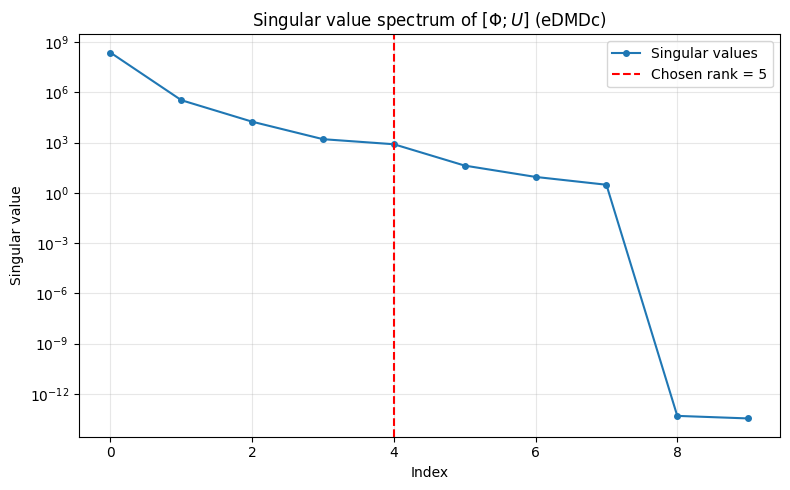

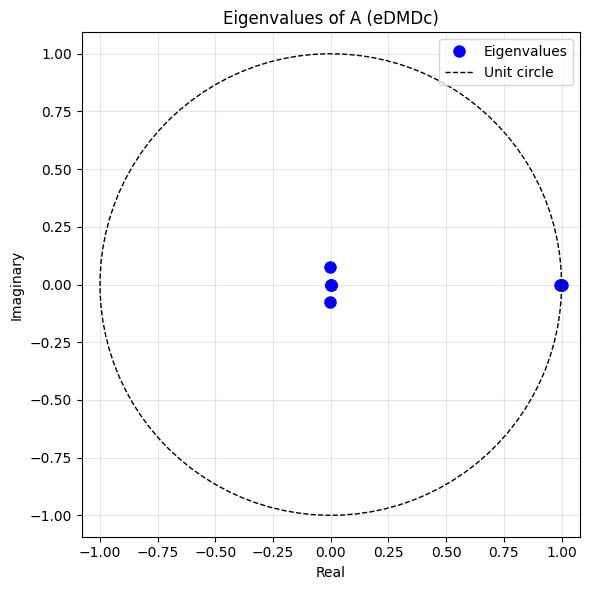

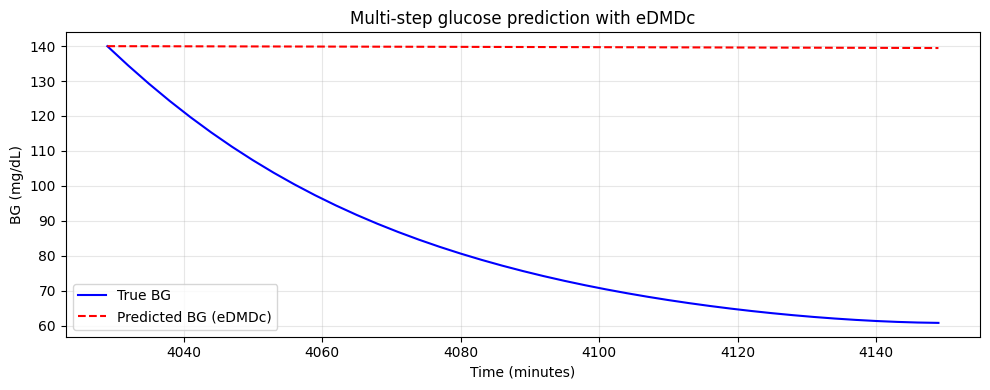


Training and evaluation complete.


In [24]:
# glycoSMC/koopman/train_edmdc.py

import os
import numpy as np
import matplotlib.pyplot as plt



def main():
    # -------------------- Data Loading --------------------
    data_dir = os.path.join('..', 'data')
    print("Loading data...")
    data = load_data(data_dir, fill_nans=True)
    BG = data['BG']
    insulin = data['insulin']
    meal = data['meal']
    t_minutes = data['t_minutes']
    print(f"Total samples: {len(BG)}")

    # -------------------- Lifting --------------------
    print("\nApplying nonlinear feature lifting...")
    Phi = lift_features(BG, insulin, meal)   # shape (n_features, T)
    n_features, T = Phi.shape
    print(f"Lifted state dimension: {n_features}")
    print(f"Number of time steps: {T}")

    # Construct Phi_next (shifted by one) and U (control input)
    # We need aligned pairs: (Phi_k, u_k) → Phi_{k+1}
    # Use all but the last sample for Phi, and all but the first for Phi_next.
    # U corresponds to u_k.
    Phi_k = Phi[:, :-1]                # shape (n_features, T-1)
    Phi_kp1 = Phi[:, 1:]               # shape (n_features, T-1)
    U = np.vstack([insulin[:-1], meal[:-1]])   # shape (2, T-1)

    # -------------------- Train / Test Split --------------------
    # Use first 80% of snapshots for training, last 20% for testing
    N = Phi_k.shape[1]
    split_idx = int(0.8 * N)
    Phi_train = Phi_k[:, :split_idx]
    Phi_next_train = Phi_kp1[:, :split_idx]
    U_train = U[:, :split_idx]

    Phi_test = Phi_k[:, split_idx:]
    Phi_next_test = Phi_kp1[:, split_idx:]
    U_test = U[:, split_idx:]

    print(f"\nTraining snapshots: {Phi_train.shape[1]}")
    print(f"Testing snapshots : {Phi_test.shape[1]}")

    # -------------------- Train with different ranks --------------------
    ranks_to_try = [None, 3, 4, 5]   # None means full rank
    results = {}

    for rank in ranks_to_try:
        rank_str = "full" if rank is None else f"rank={rank}"
        print(f"\n--- Training with {rank_str} ---")
        A, B, s = fit_edmdc(Phi_train, Phi_next_train, U_train, rank=rank)

        # Store results for later comparison
        results[rank_str] = {'A': A, 'B': B, 's': s}

        # Compute eigenvalues and time constants
        eigvals = np.linalg.eigvals(A)
        dt = 3.0  # minutes
        tau = -dt / np.log(np.abs(eigvals))
        stable_modes = [i for i, ev in enumerate(eigvals) if np.abs(ev) < 1.0]
        print(f"Number of stable modes: {len(stable_modes)}")
        if stable_modes:
            print("Estimated time constants (minutes) for stable modes:")
            for i in stable_modes[:3]:   # show first few
                print(f"  Mode {i+1}: |λ|={np.abs(eigvals[i]):.4f}, τ={tau[i]:.2f} min")

    # -------------------- Choose best rank based on test RMSE --------------------
    # We'll evaluate 2‑hour prediction (40 steps) on test set for each rank
    prediction_steps = 40
    if prediction_steps > Phi_test.shape[1]:
        prediction_steps = Phi_test.shape[1] - 1

    # True glucose over the horizon (first component of lifted state)
    # We need the initial lifted state and the corresponding true BG sequence.
    # We'll use the first test snapshot as initial condition.
    phi0 = Phi_test[:, 0]
    U_seq = U_test[:, :prediction_steps]
    true_glucose = Phi_test[0, :prediction_steps+1]   # first feature is BG

    print("\n--- Evaluating on test set (2‑hour prediction) ---")
    best_rmse = np.inf
    best_rank_str = None
    best_A = None
    best_B = None

    for rank_str, model in results.items():
        A = model['A']
        B = model['B']
        Phi_pred = predict_multi_step_edmdc(A, B, phi0, U_seq)
        pred_glucose = Phi_pred[0, :]   # first feature is BG
        rmse = compute_rmse(true_glucose, pred_glucose)
        results[rank_str]['rmse'] = rmse
        print(f"{rank_str}: RMSE = {rmse:.2f} mg/dL")
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank_str = rank_str
            best_A = A
            best_B = B

    print(f"\nBest model: {best_rank_str} with RMSE = {best_rmse:.2f} mg/dL")

    # -------------------- Plot singular values for the best model --------------------
    # Use the singular values from the full rank training for illustration
    s_full = results['full']['s']
    rank_chosen = 4 if best_rank_str == 'rank=4' else (5 if best_rank_str == 'rank=5' else None)
    fig_sv = plot_singular_values_edmdc(s_full, rank_choice=rank_chosen)
    plt.savefig('edmdc_singular_values.png', dpi=150)
    plt.show()

    # -------------------- Plot eigenvalues for the best model --------------------
    fig_eig = plot_eigenvalues_edmdc(best_A)
    plt.savefig('edmdc_eigenvalues.png', dpi=150)
    plt.show()

    # -------------------- Plot prediction for the best model --------------------
    # Recompute prediction with best model
    Phi_pred_best = predict_multi_step_edmdc(best_A, best_B, phi0, U_seq)
    pred_glucose_best = Phi_pred_best[0, :]
    start_time = t_minutes[split_idx] if split_idx < len(t_minutes) else t_minutes[-1]
    time_axis = start_time + np.arange(prediction_steps+1) * 3.0
    fig_pred = plot_predictions_edmdc(time_axis, true_glucose, pred_glucose_best)
    plt.savefig('edmdc_prediction.png', dpi=150)
    plt.show()

    print("\nTraining and evaluation complete.")

if __name__ == '__main__':
    main()

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd

# ----------------------------------------------------------------------
# Data loading
# ----------------------------------------------------------------------
def load_data(data_dir):
    """Load and concatenate all CSV files from data_dir."""
    base_path = os.path.abspath(data_dir)
    csv_files = [f for f in os.listdir(base_path) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base_path}")

    df_list = []
    for f in csv_files:
        df_list.append(pd.read_csv(os.path.join(base_path, f), parse_dates=['time']))
    df = pd.concat(df_list, ignore_index=True)
    df.sort_values(['patient', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Fill missing values (forward then backward) within each patient
    essential = ['BG', 'insulin', 'meal']
    if df[essential].isnull().any().any():
        df[essential] = df.groupby('patient')[essential].transform(lambda g: g.ffill().bfill())
        if df[essential].isnull().any().any():
            raise ValueError("Unable to fill all NaNs. Check the data.")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = df['t_minutes'].values.astype(float)
    return BG, insulin, meal, t_minutes

# ----------------------------------------------------------------------
# Normalization
# ----------------------------------------------------------------------
def normalize_train_test(train, test):
    """Standardize to zero mean, unit variance using training statistics."""
    mean = np.mean(train, axis=0, keepdims=True)
    std = np.std(train, axis=0, keepdims=True)
    std[std == 0] = 1.0   # avoid division by zero
    train_norm = (train - mean) / std
    test_norm = (test - mean) / std
    return train_norm, test_norm, mean.ravel(), std.ravel()

# ----------------------------------------------------------------------
# Feature lifting (no cubic terms)
# ----------------------------------------------------------------------
def lift_features(BG, insulin, meal):
    """
    Construct lifted feature matrix Φ from normalized variables.
    Features: [g, g², u_i, u_m, g*u_i, g*u_m]
    Returns array of shape (6, T).
    """
    BG = BG.ravel()
    insulin = insulin.ravel()
    meal = meal.ravel()
    T = len(BG)
    Phi = np.zeros((6, T))
    Phi[0, :] = BG
    Phi[1, :] = BG ** 2
    Phi[2, :] = insulin
    Phi[3, :] = meal
    Phi[4, :] = BG * insulin
    Phi[5, :] = BG * meal
    return Phi

# ----------------------------------------------------------------------
# Build eDMDc data matrices
# ----------------------------------------------------------------------
def build_matrices(Phi, U):
    """
    From lifted features Φ (6 x T) and control inputs U (2 x T),
    construct X = Φ_k, X' = Φ_{k+1}, Umat = u_k for k = 0..T-2.
    Returns X, Xprime, Umat each as 2D arrays (features x snapshots).
    """
    T = Phi.shape[1]
    X = Phi[:, :-1]               # Φ_k
    Xprime = Phi[:, 1:]            # Φ_{k+1}
    Umat = U[:, :-1]               # u_k
    return X, Xprime, Umat

# ----------------------------------------------------------------------
# Ridge regression solution for eDMDc
# ----------------------------------------------------------------------
def fit_edmdc_ridge(X, Xprime, U, lambda_reg=1e-4):
    """
    Solve [A B] = X' Ωᵀ (Ω Ωᵀ + λI)^{-1} with Ω = [X; U].
    Returns A (6x6), B (6x2).
    """
    n = X.shape[0]          # feature dimension
    m = U.shape[0]          # input dimension
    Omega = np.vstack([X, U])   # (n+m) x N
    # Compute M = X' Ωᵀ
    M = Xprime @ Omega.T        # n x (n+m)
    # Gram matrix G = Ω Ωᵀ + λI
    G = Omega @ Omega.T + lambda_reg * np.eye(n + m)
    # Solve G * Y = Mᵀ  => Y = (A B)ᵀ
    Y = np.linalg.solve(G, M.T)   # (n+m) x n
    AB = Y.T                      # n x (n+m)
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# ----------------------------------------------------------------------
# Truncated SVD solution for eDMDc
# ----------------------------------------------------------------------
def fit_edmdc_truncated(X, Xprime, U, rank):
    """
    Use truncated SVD of Ω = [X; U] to compute [A B] = X' Ω^†.
    rank can be an integer or 'full' (all singular values).
    Returns A (6x6), B (6x2).
    """
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full':
        r = len(s)
    else:
        r = int(rank)
        if r > len(s):
            r = len(s)
    # Pseudoinverse: Vh[:r].T @ diag(1/s[:r]) @ U1[:, :r].T
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# ----------------------------------------------------------------------
# Multi-step prediction
# ----------------------------------------------------------------------
def predict_multi_step(A, B, phi0, U_seq, scaler):
    """
    Roll out the model for len(U_seq) steps.
    phi0: initial lifted state (6,)
    U_seq: input sequence (2, steps)
    scaler: tuple (mean_g, std_g) for denormalizing glucose (first feature)
    Returns predicted glucose (mg/dL) over steps+1 points.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    # Denormalize glucose (first feature)
    mean_g, std_g = scaler
    glucose_pred = Phi_pred[0, :] * std_g + mean_g
    return glucose_pred

def compute_rmse(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

# ----------------------------------------------------------------------
# Plotting functions
# ----------------------------------------------------------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-')
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular value spectrum of Ω')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(eigvals), np.imag(eigvals), 'bo', markersize=6)
    # unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of A')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', label='True BG')
    plt.plot(time_axis, pred, 'r--', label='Predicted BG (eDMDc)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('Multi‑step glucose prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# ----------------------------------------------------------------------
# Main pipeline
# ----------------------------------------------------------------------
def main():
    # -------------------- 1. Load data --------------------
    data_dir = os.path.join('..', 'data')
    BG, insulin, meal, t_minutes = load_data(data_dir)
    T_total = len(BG)
    print(f"Total samples: {T_total}")

    # -------------------- 2. Train/test split (80/20) --------------------
    split_idx = int(0.8 * T_total)
    BG_train, BG_test = BG[:split_idx], BG[split_idx:]
    ins_train, ins_test = insulin[:split_idx], insulin[split_idx:]
    meal_train, meal_test = meal[:split_idx], meal[split_idx:]
    t_train, t_test = t_minutes[:split_idx], t_minutes[split_idx:]

    # -------------------- 3. Normalize using training statistics --------------------
    # Stack variables to normalize together (each variable separately)
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    test_stack = np.column_stack([BG_test, ins_test, meal_test])
    train_norm, test_norm, means, stds = normalize_train_test(train_stack, test_stack)
    BG_train_n, ins_train_n, meal_train_n = train_norm[:,0], train_norm[:,1], train_norm[:,2]
    BG_test_n, ins_test_n, meal_test_n = test_norm[:,0], test_norm[:,1], test_norm[:,2]

    # -------------------- 4. Feature lifting --------------------
    Phi_train = lift_features(BG_train_n, ins_train_n, meal_train_n)   # (6, T_train)
    Phi_test = lift_features(BG_test_n, ins_test_n, meal_test_n)       # (6, T_test)

    # Build control input matrices (normalized)
    U_train = np.vstack([ins_train_n, meal_train_n])   # (2, T_train)
    U_test = np.vstack([ins_test_n, meal_test_n])      # (2, T_test)

    # -------------------- 5. Build eDMDc data matrices (aligned pairs) --------------------
    X_train, Xprime_train, Umat_train = build_matrices(Phi_train, U_train)
    X_test, Xprime_test, Umat_test = build_matrices(Phi_test, U_test)

    # -------------------- 6. Prepare for rank sweep --------------------
    # Compute full SVD of Ω_train for later use in truncated solutions
    Omega_train = np.vstack([X_train, Umat_train])
    U_svd, s, Vh = svd(Omega_train, full_matrices=False)

    # Ridge solution (full rank, regularized)
    print("\n--- Training with ridge (λ=1e-4) ---")
    A_ridge, B_ridge = fit_edmdc_ridge(X_train, Xprime_train, Umat_train, lambda_reg=1e-4)

    # Candidate ranks: full ridge, and truncated SVD with ranks 2..6
    ranks = ['ridge', 2, 3, 4, 5, 6]
    results = {}

    # Evaluate ridge model
    # Need initial state for test prediction: use first test lifted state
    phi0_test = X_test[:, 0]   # corresponds to Φ at test index 0
    U_seq_test = Umat_test      # inputs for steps 0..N-2
    # We will predict up to 40 steps (or less if test set is shorter)
    max_steps = min(40, X_test.shape[1] - 1)   # because we need one extra for true next
    if max_steps < 1:
        raise ValueError("Test set too short for 2‑hour prediction.")

    true_glucose_denorm = BG_test[1:1+max_steps+1]  # align with predicted: start from second test sample? Wait careful.
    # The test lifted states X_test correspond to Φ_k for k in test set indices 0..L-2.
    # The first test state is at original time index split_idx+? Let's derive properly.
    # After lifting, the test lifted states X_test have columns corresponding to k from 0 to L-2.
    # The true glucose for these states is the first feature of X_test, but that's normalized.
    # To get denormalized glucose, we can use BG_test[1:] because X_test uses BG_test[1:] as the first feature? Actually:
    # X_test[:, i] = Φ at test time index i (which uses BG_test[i] as first feature). Then Xprime_test[:, i] uses BG_test[i+1].
    # So for prediction starting from phi0 = X_test[:,0], we need to predict BG_test[1], BG_test[2], ... .
    # The true glucose sequence for steps 0..max_steps (inclusive of initial) should be BG_test[0] (initial) and then predicted steps.
    # But we only care about prediction after step 0. We'll compute RMSE on steps 1..max_steps+1 (the predicted ones).
    # Let's define:
    true_glucose_denorm = BG_test[1:1+max_steps+1]   # length max_steps+1? Actually we predict max_steps steps, so we get max_steps+1 predicted points including initial.
    # If we predict max_steps steps, we have predicted glucose at times 0..max_steps. The true glucose at those times is BG_test[0:max_steps+1].
    # So we should align indices carefully.
    # Simpler: we will use the first max_steps+1 true glucose values from test set (starting at test index 0) for comparison.
    true_glucose_denorm = BG_test[:max_steps+1]   # length max_steps+1
    # Then we predict with U_seq_test[:, :max_steps] (inputs for steps 0..max_steps-1)
    U_seq_test_trunc = Umat_test[:, :max_steps]
    scaler = (means[0], stds[0])   # for glucose

    # Ridge prediction
    pred_ridge = predict_multi_step(A_ridge, B_ridge, phi0_test, U_seq_test_trunc, scaler)
    rmse_ridge = compute_rmse(true_glucose_denorm, pred_ridge)
    results['ridge'] = {'A': A_ridge, 'B': B_ridge, 'rmse': rmse_ridge}
    print(f"Ridge (full): RMSE = {rmse_ridge:.2f} mg/dL")

    # Evaluate truncated models
    for r in ranks[1:]:
        print(f"\n--- Training with rank {r} (truncated SVD) ---")
        A_trunc, B_trunc = fit_edmdc_truncated(X_train, Xprime_train, Umat_train, rank=r)
        pred_trunc = predict_multi_step(A_trunc, B_trunc, phi0_test, U_seq_test_trunc, scaler)
        rmse_trunc = compute_rmse(true_glucose_denorm, pred_trunc)
        results[r] = {'A': A_trunc, 'B': B_trunc, 'rmse': rmse_trunc}
        print(f"Rank {r}: RMSE = {rmse_trunc:.2f} mg/dL")

    # -------------------- 7. Select best rank --------------------
    best_rank = min(results, key=lambda k: results[k]['rmse'])
    best_rmse = results[best_rank]['rmse']
    best_A = results[best_rank]['A']
    best_B = results[best_rank]['B']
    print(f"\n*** Best model: {best_rank} with RMSE = {best_rmse:.2f} mg/dL ***")

    # -------------------- 8. Eigenanalysis of best model --------------------
    eigvals = np.linalg.eigvals(best_A)
    dt = 3.0   # minutes
    tau = -dt / np.log(np.abs(eigvals))
    print("\nTime constants for stable modes (|λ|<1):")
    for i, (ev, tc) in enumerate(zip(eigvals, tau)):
        if np.abs(ev) < 1.0:
            print(f"  Mode {i+1}: |λ|={np.abs(ev):.4f}, τ={tc:.2f} min")

    # -------------------- 9. Generate plots --------------------
    # Singular value spectrum of Omega_train
    plot_singular_values(s, 'edmdc_singular_values.png')
    # Eigenvalues of best A
    plot_eigenvalues(best_A, 'edmdc_eigenvalues.png')
    # Prediction plot
    time_axis = t_test[0] + np.arange(max_steps+1) * dt
    # Use best model prediction (already computed)
    if best_rank == 'ridge':
        pred_best = pred_ridge
    else:
        pred_best = predict_multi_step(best_A, best_B, phi0_test, U_seq_test_trunc, scaler)
    plot_predictions(time_axis, true_glucose_denorm, pred_best, 'edmdc_prediction.png')

    print("\nPlots saved: edmdc_singular_values.png, edmdc_eigenvalues.png, edmdc_prediction.png")
    print("Pipeline finished successfully.")

if __name__ == '__main__':
    main()

Total samples: 10083

--- Training with ridge (λ=1e-4) ---
Ridge (full): RMSE = 56.12 mg/dL

--- Training with rank 2 (truncated SVD) ---
Rank 2: RMSE = 45.62 mg/dL

--- Training with rank 3 (truncated SVD) ---
Rank 3: RMSE = 45.14 mg/dL

--- Training with rank 4 (truncated SVD) ---
Rank 4: RMSE = 55.99 mg/dL

--- Training with rank 5 (truncated SVD) ---
Rank 5: RMSE = 55.98 mg/dL

--- Training with rank 6 (truncated SVD) ---
Rank 6: RMSE = 56.12 mg/dL

*** Best model: 3 with RMSE = 45.14 mg/dL ***

Time constants for stable modes (|λ|<1):
  Mode 1: |λ|=0.9955, τ=664.09 min
  Mode 2: |λ|=0.0398, τ=0.93 min
  Mode 3: |λ|=0.0398, τ=0.93 min
  Mode 4: |λ|=0.0000, τ=0.08 min
  Mode 5: |λ|=0.0000, τ=0.07 min
  Mode 6: |λ|=0.0000, τ=0.07 min

Plots saved: edmdc_singular_values.png, edmdc_eigenvalues.png, edmdc_prediction.png
Pipeline finished successfully.


In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
eDMDc Full Pipeline for Glucose-Insulin System
===============================================
Research‑grade implementation of Extended Dynamic Mode Decomposition with control
using delay embedding and nonlinear lifting.

Features:
- Data loading, resampling, missing value interpolation
- Z‑score normalization (fit on training)
- Delay embedding of BG, insulin, meal
- Nonlinear lifting: identity, quadratic, cross terms, optional RBF
- Training: Ridge regression and truncated SVD with automatic rank selection
- Model selection based on 2‑hour prediction RMSE on validation set
- Eigenvalue analysis and time constants
- Multi‑step prediction and evaluation
- Saving of model and scaling parameters
- Publication‑quality plots
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd, solve, eig

# -------------------- Configuration --------------------
# User‑adjustable parameters
D = 4                      # number of delays for each variable
USE_POLY = True            # include polynomial terms (identity already included)
USE_RBF = False            # include radial basis functions (experimental)
RBF_CENTERS = 5            # number of centers per dimension if USE_RBF=True
LAMBDA_RIDGE = 1e-4        # ridge regularisation parameter
ENERGY_THRESHOLD = 0.999   # cumulative energy for automatic rank (if not using CV)
PREDICTION_HORIZON = 40    # 40 steps * 3 min = 120 min
TRAIN_FRAC = 0.8           # fraction of data for training (chronological)
VAL_FRAC = 0.1             # fraction of training for validation (rest for training)
RANDOM_SEED = 42            # for reproducibility

np.random.seed(RANDOM_SEED)

# -------------------- Data Loading & Preprocessing --------------------
def load_and_preprocess(data_dir, target_dt=3.0):
    """
    Load all CSV files from data_dir, concatenate, sort, and ensure uniform
    sampling with missing value interpolation.
    """
    base = os.path.abspath(data_dir)
    csv_files = [f for f in os.listdir(base) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base}")

    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(base, f), parse_dates=['time'])
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values(['patient', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Check if sampling is uniform; if not, resample per patient
    # We'll trust the provided t_minutes and assume uniform 3 min.
    # But verify and interpolate missing values if needed.
    essential = ['BG', 'insulin', 'meal']
    for col in essential:
        if df[col].isnull().any():
            # Linear interpolation per patient
            df[col] = df.groupby('patient')[col].transform(
                lambda s: s.interpolate(method='linear', limit_direction='both')
            )
    # Final check
    if df[essential].isnull().any().any():
        raise ValueError("NaNs remain after interpolation. Check data.")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = df['t_minutes'].values.astype(float)

    # Ensure uniform spacing (warn if not)
    diffs = np.diff(t_minutes)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, target_dt):
        print(f"Warning: Sampling interval not uniform {target_dt} min. Found {unique_diffs}")
    return BG, insulin, meal, t_minutes

# -------------------- Normalization --------------------
def compute_normalization(train_data):
    """Compute mean and std for each column, handling zero std."""
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    std[std == 0] = 1.0
    return mean, std

def normalize(data, mean, std):
    return (data - mean) / std

def denormalize(data_norm, mean, std):
    return data_norm * std + mean

# -------------------- Delay Embedding --------------------
def delay_embedding(data, d):
    """
    data: 1D array of length T
    returns: matrix of shape (d, T-d+1) with columns [x_k, x_{k-1}, ..., x_{k-d+1}]^T
    """
    T = len(data)
    n = T - d + 1
    X = np.zeros((d, n))
    for i in range(d):
        X[i, :] = data[d-1-i : T-i]
    return X

# -------------------- Nonlinear Lifting --------------------
def rbf_centers_from_data(data, n_centers):
    """Compute quantile‑based centers for each column of data (each variable)."""
    centers = []
    for col in range(data.shape[1]):
        q = np.linspace(0, 100, n_centers+2)[1:-1]  # exclude 0 and 100
        cents = np.percentile(data[:, col], q)
        centers.append(cents)
    return np.array(centers)  # shape (n_vars, n_centers)

def rbf_features(x, centers, gamma=1.0):
    """
    x: single sample (n_vars,)
    centers: (n_vars, n_centers)
    returns: RBF features (n_vars * n_centers,)
    """
    n_vars, n_centers = centers.shape
    phi = np.zeros(n_vars * n_centers)
    idx = 0
    for i in range(n_vars):
        for j in range(n_centers):
            phi[idx] = np.exp(-gamma * (x[i] - centers[i, j])**2)
            idx += 1
    return phi

def lift_features(Z, config):
    """
    Z: raw delayed state matrix (n_vars * D, N)  [each column is z_k]
    config: dict with keys USE_POLY, USE_RBF, rbf_centers (if needed)
    Returns: lifted feature matrix Phi (n_features, N)
    """
    N = Z.shape[1]
    features = [Z]  # start with identity (the raw delayed state)

    if config['USE_POLY']:
        # Quadratic terms: squares and cross products
        # For computational efficiency, we generate all pairwise products (including squares)
        # using outer product and take upper triangle.
        ZT = Z.T  # (N, n_raw)
        n_raw = Z.shape[0]
        quad = []
        for i in range(n_raw):
            for j in range(i, n_raw):
                quad.append(ZT[:, i] * ZT[:, j])
        quad = np.array(quad).T  # (N, n_quad)
        features.append(quad.T)   # (n_quad, N)

    if config['USE_RBF']:
        # RBF features: for each sample, compute RBF for each variable using centers
        # centers stored in config['rbf_centers'] (n_vars, n_centers)
        centers = config['rbf_centers']
        gamma = config.get('rbf_gamma', 1.0)
        n_vars = centers.shape[0]
        n_centers = centers.shape[1]
        rbf_list = []
        for k in range(N):
            rbf_list.append(rbf_features(Z[:, k], centers, gamma))
        rbf_mat = np.array(rbf_list).T  # (n_vars*n_centers, N)
        features.append(rbf_mat)

    Phi = np.vstack(features)   # (n_features, N)
    return Phi

# -------------------- Build eDMDc Data Matrices --------------------
def build_edmdc_matrices(Phi, U):
    """
    Phi: lifted features (n_features, T)
    U: control inputs (2, T)   [insulin; meal]
    Returns: X (n_features, N), Xprime (n_features, N), Umat (2, N)
    where N = T-1, X = Phi_k, Xprime = Phi_{k+1}, Umat = u_k
    """
    T = Phi.shape[1]
    X = Phi[:, :-1]
    Xprime = Phi[:, 1:]
    Umat = U[:, :-1]
    return X, Xprime, Umat

# -------------------- Training Methods --------------------
def train_ridge(X, Xprime, U, lam):
    """Solve [A B] = X' Omega^T (Omega Omega^T + lam I)^{-1}"""
    n = X.shape[0]
    m = U.shape[0]
    Omega = np.vstack([X, U])               # (n+m, N)
    # M = X' Omega^T
    M = Xprime @ Omega.T                     # (n, n+m)
    # Gram = Omega Omega^T + lam I
    Gram = Omega @ Omega.T + lam * np.eye(n + m)
    # Solve Gram * Y = M^T   -> Y = (A B)^T
    Y = solve(Gram, M.T, assume_a='pos')     # (n+m, n)
    AB = Y.T                                  # (n, n+m)
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

def train_truncated_svd(X, Xprime, U, rank):
    """Use truncated SVD of Omega to compute [A B] = X' Omega^†"""
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full':
        r = len(s)
    else:
        r = int(rank)
        if r > len(s):
            r = len(s)
    # Pseudoinverse: Vh[:r].T @ diag(1/s[:r]) @ U1[:, :r].T
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# -------------------- Multi‑step Prediction --------------------
def predict_multi_step(A, B, phi0, U_seq, mean_g, std_g):
    """
    Roll out model for len(U_seq) steps.
    phi0: initial lifted state (n_features,)
    U_seq: (2, steps) inputs
    Returns predicted glucose (mg/dL) of length steps+1.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    # First feature is normalized glucose (identity)
    glucose_norm = Phi_pred[0, :]
    glucose = denormalize(glucose_norm, mean_g, std_g)
    return glucose

def compute_metrics(true, pred):
    rmse = np.sqrt(np.mean((true - pred)**2))
    mae = np.mean(np.abs(true - pred))
    nrmse = rmse / (np.max(true) - np.min(true)) if np.max(true) != np.min(true) else np.nan
    return rmse, mae, nrmse

# -------------------- Rank Selection --------------------
def select_rank_by_validation(X_tr, Xpr_tr, U_tr,
                              X_val, Xpr_val, U_val,
                              mean_g, std_g,
                              rank_list, method='svd'):
    """
    For each rank, train on X_tr,... and compute validation RMSE over 2h prediction.
    Returns best rank and corresponding A,B.
    """
    best_rank = None
    best_rmse = np.inf
    best_A = None
    best_B = None
    # Initial state for validation: first column of X_val
    phi0_val = X_val[:, 0]
    # Input sequence for validation: U_val (all columns, but we limit to horizon)
    steps = min(PREDICTION_HORIZON, X_val.shape[1] - 1)   # need at least one step
    U_seq_val = U_val[:, :steps]
    # True glucose for those steps: we need the true glucose values from validation set
    # The true glucose is the first component of X_val (normalized). But X_val corresponds to states at times 0..N-1.
    # The predictions will be for times 1..steps+1 relative to initial state.
    # So true glucose for steps 1..steps+1 is the first component of Xprime_val[:, :steps]? Actually Xprime_val[k] is Φ_{k+1}.
    # So glucose at time k+1 (normalized) is Xprime_val[0, k]. For steps steps, we need steps+1 true values (including initial).
    # We'll extract true normalized glucose from X_val and Xprime_val.
    true_norm = np.concatenate([[X_val[0,0]], Xprime_val[0, :steps]])
    true_glucose = denormalize(true_norm, mean_g, std_g)

    for rank in rank_list:
        if method == 'svd':
            A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        else:
            # ridge method not used here; rank_list could be just one lambda
            continue
        pred_glucose = predict_multi_step(A, B, phi0_val, U_seq_val, mean_g, std_g)
        rmse = compute_metrics(true_glucose, pred_glucose)[0]
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank = rank
            best_A = A.copy()
            best_B = B.copy()
    return best_rank, best_A, best_B, best_rmse

# -------------------- Plotting --------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-', markersize=4)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular Value Spectrum of $\\Omega$')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    # color stable (inside unit circle) vs unstable
    stable = np.abs(eigvals) < 1.0
    plt.plot(np.real(eigvals[stable]), np.imag(eigvals[stable]), 'bo', label='Stable')
    plt.plot(np.real(eigvals[~stable]), np.imag(eigvals[~stable]), 'rx', label='Unstable')
    # unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of $A$')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred, 'r--', linewidth=1.5, label='Predicted BG')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('2‑Hour Glucose Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_residuals(time_axis, residuals, save_path):
    plt.figure(figsize=(10,3))
    plt.plot(time_axis, residuals, 'k-', linewidth=0.8)
    plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Residual (mg/dL)')
    plt.title('Prediction Residuals')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# -------------------- Main Pipeline --------------------
def main():
    print("=== eDMDc Full Pipeline ===")
    print(f"Delays: {D}")
    print(f"Polynomial terms: {USE_POLY}")
    print(f"RBF features: {USE_RBF}")
    print(f"Ridge lambda: {LAMBDA_RIDGE}")
    print(f"Energy threshold: {ENERGY_THRESHOLD}")
    print(f"Prediction horizon: {PREDICTION_HORIZON} steps ({PREDICTION_HORIZON*3} min)")

    # 1. Load data
    data_dir = os.path.join('..', 'data')
    BG, insulin, meal, t_minutes = load_and_preprocess(data_dir)

    T_total = len(BG)
    print(f"\nTotal samples: {T_total}")

    # 2. Chronological split
    train_end = int(TRAIN_FRAC * T_total)
    val_end = train_end + int(VAL_FRAC * T_total)
    # train: 0..train_end-1, val: train_end..val_end-1, test: val_end..end
    if val_end >= T_total:
        # Adjust if VAL_FRAC too large
        val_end = T_total
        test_end = T_total
    else:
        test_end = T_total

    train_slice = slice(0, train_end)
    val_slice = slice(train_end, val_end)
    test_slice = slice(val_end, test_end)

    BG_train, BG_val, BG_test = BG[train_slice], BG[val_slice], BG[test_slice]
    ins_train, ins_val, ins_test = insulin[train_slice], insulin[val_slice], insulin[test_slice]
    meal_train, meal_val, meal_test = meal[train_slice], meal[val_slice], meal[test_slice]
    t_train, t_val, t_test = t_minutes[train_slice], t_minutes[val_slice], t_minutes[test_slice]

    print(f"Train: {len(BG_train)} samples")
    print(f"Validation: {len(BG_val)} samples")
    print(f"Test: {len(BG_test)} samples")

    # 3. Normalize using training data
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    mean, std = compute_normalization(train_stack)
    mean_g, std_g = mean[0], std[0]
    mean_i, std_i = mean[1], std[1]
    mean_m, std_m = mean[2], std[2]

    # Normalize all sets
    BG_train_n = normalize(BG_train, mean_g, std_g)
    ins_train_n = normalize(ins_train, mean_i, std_i)
    meal_train_n = normalize(meal_train, mean_m, std_m)

    BG_val_n = normalize(BG_val, mean_g, std_g)
    ins_val_n = normalize(ins_val, mean_i, std_i)
    meal_val_n = normalize(meal_val, mean_m, std_m)

    BG_test_n = normalize(BG_test, mean_g, std_g)
    ins_test_n = normalize(ins_test, mean_i, std_i)
    meal_test_n = normalize(meal_test, mean_m, std_m)

    # 4. Delay embedding (for each variable separately)
    # We need to ensure enough samples after delay. We'll embed each variable, then stack vertically.
    # For training set, we have T_train samples. After delay D, we get N_train = T_train - D + 1 snapshots.
    # For validation and test, we also need to align indices. We'll embed each set separately,
    # but the first valid snapshot for training starts at index D-1.
    # We'll keep only the common time range where all variables have valid delays.
    # Since we are embedding each variable independently, we can just compute their delayed matrices
    # and then slice to the same number of columns (they will have same number of columns if T is same).
    # But after embedding, each variable matrix has shape (D, T - D + 1). So number of columns is the same.
    # We'll stack row-wise to get raw state z_k.

    def build_raw_state(BG_n, ins_n, meal_n, D):
        Xg = delay_embedding(BG_n, D)
        Xi = delay_embedding(ins_n, D)
        Xm = delay_embedding(meal_n, D)
        # Check they have same number of columns
        assert Xg.shape[1] == Xi.shape[1] == Xm.shape[1]
        Z = np.vstack([Xg, Xi, Xm])   # shape (3*D, N)
        return Z

    Z_train = build_raw_state(BG_train_n, ins_train_n, meal_train_n, D)
    Z_val = build_raw_state(BG_val_n, ins_val_n, meal_val_n, D)
    Z_test = build_raw_state(BG_test_n, ins_test_n, meal_test_n, D)

    # Build control input matrices (normalized) for the same snapshots.
    # The control input at time k is [insulin_k, meal_k]^T.
    # After delay embedding, the snapshots correspond to indices D-1 ... T-1.
    # So we need U of shape (2, N) for the same indices.
    def get_U(ins_n, meal_n, D):
        # Starting index for first snapshot is D-1
        start = D - 1
        U = np.vstack([ins_n[start:], meal_n[start:]])   # (2, T - start)
        # Number of columns should equal N = T - D + 1
        assert U.shape[1] == len(ins_n) - start
        return U

    U_train = get_U(ins_train_n, meal_train_n, D)
    U_val = get_U(ins_val_n, meal_val_n, D)
    U_test = get_U(ins_test_n, meal_test_n, D)

    # 5. Prepare nonlinear lifting configuration
    lift_config = {
        'USE_POLY': USE_POLY,
        'USE_RBF': USE_RBF,
    }
    if USE_RBF:
        # Compute RBF centers from training raw state (columns of Z_train)
        # Z_train is (3*D, N_train). For RBF we treat each dimension separately.
        # We need centers for each raw state dimension.
        # Transpose to (N_train, 3*D)
        Z_train_T = Z_train.T
        centers = rbf_centers_from_data(Z_train_T, RBF_CENTERS)   # shape (3*D, RBF_CENTERS)
        lift_config['rbf_centers'] = centers
        lift_config['rbf_gamma'] = 1.0  # could be tuned

    # 6. Lift features for each set
    Phi_train = lift_features(Z_train, lift_config)
    Phi_val = lift_features(Z_val, lift_config)
    Phi_test = lift_features(Z_test, lift_config)

    print(f"Lifted feature dimension: {Phi_train.shape[0]}")

    # 7. Build eDMDc matrices (X, Xprime, U)
    X_tr, Xpr_tr, U_tr = build_edmdc_matrices(Phi_train, U_train)
    X_val, Xpr_val, U_val_m = build_edmdc_matrices(Phi_val, U_val)
    X_te, Xpr_te, U_te = build_edmdc_matrices(Phi_test, U_test)

    # 8. Ridge model (full rank)
    print("\n--- Training Ridge model ---")
    A_ridge, B_ridge = train_ridge(X_tr, Xpr_tr, U_tr, LAMBDA_RIDGE)

    # 9. Rank sweep using truncated SVD on validation set
    # Determine maximum possible rank
    n_features = X_tr.shape[0]
    max_rank = min(n_features + U_tr.shape[0], X_tr.shape[1])  # Omega size
    rank_list = list(range(2, max_rank+1))   # start from 2 to avoid rank 1 (too simple)
    print(f"\n--- Selecting rank via validation (ranks {rank_list[0]}-{rank_list[-1]}) ---")
    best_rank, A_svd, B_svd, best_val_rmse = select_rank_by_validation(
        X_tr, Xpr_tr, U_tr,
        X_val, Xpr_val, U_val_m,
        mean_g, std_g,
        rank_list, method='svd'
    )
    print(f"Best rank: {best_rank} with validation RMSE = {best_val_rmse:.2f} mg/dL")

    # 10. Evaluate on test set using best SVD model
    # Initial test state: first column of X_te
    phi0_test = X_te[:, 0]
    steps_test = min(PREDICTION_HORIZON, X_te.shape[1] - 1)
    U_seq_test = U_te[:, :steps_test]
    true_norm_test = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps_test]])
    true_glucose_test = denormalize(true_norm_test, mean_g, std_g)

    pred_ridge_test = predict_multi_step(A_ridge, B_ridge, phi0_test, U_seq_test, mean_g, std_g)
    pred_svd_test = predict_multi_step(A_svd, B_svd, phi0_test, U_seq_test, mean_g, std_g)

    rmse_ridge, mae_ridge, nrmse_ridge = compute_metrics(true_glucose_test, pred_ridge_test)
    rmse_svd, mae_svd, nrmse_svd = compute_metrics(true_glucose_test, pred_svd_test)

    print("\n--- Test Set Results (2‑hour prediction) ---")
    print(f"Ridge: RMSE = {rmse_ridge:.2f} mg/dL, MAE = {mae_ridge:.2f}, NRMSE = {nrmse_ridge:.3f}")
    print(f"SVD (rank={best_rank}): RMSE = {rmse_svd:.2f} mg/dL, MAE = {mae_svd:.2f}, NRMSE = {nrmse_svd:.3f}")

    # 11. Eigenanalysis of best model (SVD)
    eigvals = np.linalg.eigvals(A_svd)
    dt = 3.0
    tau = -dt / np.log(np.abs(eigvals))
    print("\n--- Eigenvalues of Best Model ---")
    stable = np.abs(eigvals) < 1.0
    for i, (ev, stab) in enumerate(zip(eigvals, stable)):
        if stab:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f}, τ={tau[i]:.2f} min")
        else:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f} (UNSTABLE)")

    # 12. Plotting
    # Singular values of Omega_train (full)
    Omega_full = np.vstack([X_tr, U_tr])
    _, s, _ = svd(Omega_full, full_matrices=False)
    plot_singular_values(s, 'edmdc_singular_values.png')
    plot_eigenvalues(A_svd, 'edmdc_eigenvalues.png')

    # Prediction plot for best model
    time_axis = t_test[0] + np.arange(steps_test+1) * dt
    plot_predictions(time_axis, true_glucose_test, pred_svd_test, 'edmdc_prediction.png')
    residuals = true_glucose_test - pred_svd_test
    plot_residuals(time_axis, residuals, 'edmdc_residuals.png')

    # 13. Save model
    np.savez('edmdc_model.npz',
             A=A_svd, B=B_svd,
             mean_g=mean_g, std_g=std_g,
             mean_i=mean_i, std_i=std_i,
             mean_m=mean_m, std_m=std_m,
             D=D,
             lift_config=lift_config,
             best_rank=best_rank,
             rmse_test=rmse_svd)
    print("\nModel saved as edmdc_model.npz")

    # 14. Summary table
    print("\n=== Summary ===")
    print(f"Data: {T_total} samples, {train_end} train, {val_end-train_end} val, {test_end-val_end} test")
    print(f"Delays: {D}")
    print(f"Lifted feature dimension: {Phi_train.shape[0]}")
    print(f"Best rank: {best_rank}")
    print(f"Test RMSE (SVD): {rmse_svd:.2f} mg/dL")
    print(f"Test MAE (SVD): {mae_svd:.2f} mg/dL")
    print(f"Test NRMSE (SVD): {nrmse_svd:.3f}")
    print("Plots saved: singular_values, eigenvalues, prediction, residuals")
    print("Done.")

if __name__ == '__main__':
    main()

=== eDMDc Full Pipeline ===
Delays: 4
Polynomial terms: True
RBF features: False
Ridge lambda: 0.0001
Energy threshold: 0.999
Prediction horizon: 40 steps (120 min)

Total samples: 10083
Train: 8066 samples
Validation: 1008 samples
Test: 1009 samples
Lifted feature dimension: 90

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-92) ---


NameError: name 'Xprime_val' is not defined

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
eDMDc Full Pipeline for Glucose-Insulin System
===============================================
Research‑grade implementation of Extended Dynamic Mode Decomposition with control
using delay embedding and nonlinear lifting.

Features:
- Data loading, resampling, missing value interpolation
- Z‑score normalization (fit on training)
- Delay embedding of BG, insulin, meal
- Nonlinear lifting: identity, quadratic, cross terms, optional RBF
- Training: Ridge regression and truncated SVD with automatic rank selection
- Model selection based on 2‑hour prediction RMSE on validation set
- Eigenvalue analysis and time constants
- Multi‑step prediction and evaluation
- Saving of model and scaling parameters
- Publication‑quality plots
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd, solve, eig

# -------------------- Configuration --------------------
# User‑adjustable parameters
D = 4                      # number of delays for each variable
USE_POLY = True            # include polynomial terms (identity already included)
USE_RBF = False            # include radial basis functions (experimental)
RBF_CENTERS = 5            # number of centers per dimension if USE_RBF=True
LAMBDA_RIDGE = 1e-4        # ridge regularisation parameter
ENERGY_THRESHOLD = 0.999   # cumulative energy for automatic rank (if not using CV)
PREDICTION_HORIZON = 40    # 40 steps * 3 min = 120 min
TRAIN_FRAC = 0.8           # fraction of data for training (chronological)
VAL_FRAC = 0.1             # fraction of training for validation (rest for training)
RANDOM_SEED = 42            # for reproducibility

np.random.seed(RANDOM_SEED)

# -------------------- Data Loading & Preprocessing --------------------
def load_and_preprocess(data_dir, target_dt=3.0):
    """
    Load all CSV files from data_dir, concatenate, sort, and ensure uniform
    sampling with missing value interpolation.
    """
    base = os.path.abspath(data_dir)
    csv_files = [f for f in os.listdir(base) if f.endswith('.csv')]
    if not csv_files:
        raise RuntimeError(f"No CSV files found in {base}")

    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(base, f), parse_dates=['time'])
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df.sort_values(['patient', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Check if sampling is uniform; if not, resample per patient
    # We'll trust the provided t_minutes and assume uniform 3 min.
    # But verify and interpolate missing values if needed.
    essential = ['BG', 'insulin', 'meal']
    for col in essential:
        if df[col].isnull().any():
            # Linear interpolation per patient
            df[col] = df.groupby('patient')[col].transform(
                lambda s: s.interpolate(method='linear', limit_direction='both')
            )
    # Final check
    if df[essential].isnull().any().any():
        raise ValueError("NaNs remain after interpolation. Check data.")

    BG = df['BG'].values.astype(float)
    insulin = df['insulin'].values.astype(float)
    meal = df['meal'].values.astype(float)
    t_minutes = df['t_minutes'].values.astype(float)

    # Ensure uniform spacing (warn if not)
    diffs = np.diff(t_minutes)
    unique_diffs = np.unique(diffs)
    if not np.allclose(unique_diffs, target_dt):
        print(f"Warning: Sampling interval not uniform {target_dt} min. Found {unique_diffs}")
    return BG, insulin, meal, t_minutes

# -------------------- Normalization --------------------
def compute_normalization(train_data):
    """Compute mean and std for each column, handling zero std."""
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    std[std == 0] = 1.0
    return mean, std

def normalize(data, mean, std):
    return (data - mean) / std

def denormalize(data_norm, mean, std):
    return data_norm * std + mean

# -------------------- Delay Embedding --------------------
def delay_embedding(data, d):
    """
    data: 1D array of length T
    returns: matrix of shape (d, T-d+1) with columns [x_k, x_{k-1}, ..., x_{k-d+1}]^T
    """
    T = len(data)
    n = T - d + 1
    X = np.zeros((d, n))
    for i in range(d):
        X[i, :] = data[d-1-i : T-i]
    return X

# -------------------- Nonlinear Lifting --------------------
def rbf_centers_from_data(data, n_centers):
    """Compute quantile‑based centers for each column of data (each variable)."""
    centers = []
    for col in range(data.shape[1]):
        q = np.linspace(0, 100, n_centers+2)[1:-1]  # exclude 0 and 100
        cents = np.percentile(data[:, col], q)
        centers.append(cents)
    return np.array(centers)  # shape (n_vars, n_centers)

def rbf_features(x, centers, gamma=1.0):
    """
    x: single sample (n_vars,)
    centers: (n_vars, n_centers)
    returns: RBF features (n_vars * n_centers,)
    """
    n_vars, n_centers = centers.shape
    phi = np.zeros(n_vars * n_centers)
    idx = 0
    for i in range(n_vars):
        for j in range(n_centers):
            phi[idx] = np.exp(-gamma * (x[i] - centers[i, j])**2)
            idx += 1
    return phi

def lift_features(Z, config):
    """
    Z: raw delayed state matrix (n_vars * D, N)  [each column is z_k]
    config: dict with keys USE_POLY, USE_RBF, rbf_centers (if needed)
    Returns: lifted feature matrix Phi (n_features, N)
    """
    N = Z.shape[1]
    features = [Z]  # start with identity (the raw delayed state)

    if config['USE_POLY']:
        # Quadratic terms: squares and cross products
        # For computational efficiency, we generate all pairwise products (including squares)
        # using outer product and take upper triangle.
        ZT = Z.T  # (N, n_raw)
        n_raw = Z.shape[0]
        quad = []
        for i in range(n_raw):
            for j in range(i, n_raw):
                quad.append(ZT[:, i] * ZT[:, j])
        quad = np.array(quad).T  # (N, n_quad)
        features.append(quad.T)   # (n_quad, N)

    if config['USE_RBF']:
        # RBF features: for each sample, compute RBF for each variable using centers
        # centers stored in config['rbf_centers'] (n_vars, n_centers)
        centers = config['rbf_centers']
        gamma = config.get('rbf_gamma', 1.0)
        n_vars = centers.shape[0]
        n_centers = centers.shape[1]
        rbf_list = []
        for k in range(N):
            rbf_list.append(rbf_features(Z[:, k], centers, gamma))
        rbf_mat = np.array(rbf_list).T  # (n_vars*n_centers, N)
        features.append(rbf_mat)

    Phi = np.vstack(features)   # (n_features, N)
    return Phi

# -------------------- Build eDMDc Data Matrices --------------------
def build_edmdc_matrices(Phi, U):
    """
    Phi: lifted features (n_features, T)
    U: control inputs (2, T)   [insulin; meal]
    Returns: X (n_features, N), Xprime (n_features, N), Umat (2, N)
    where N = T-1, X = Phi_k, Xprime = Phi_{k+1}, Umat = u_k
    """
    T = Phi.shape[1]
    X = Phi[:, :-1]
    Xprime = Phi[:, 1:]
    Umat = U[:, :-1]
    return X, Xprime, Umat

# -------------------- Training Methods --------------------
def train_ridge(X, Xprime, U, lam):
    """Solve [A B] = X' Omega^T (Omega Omega^T + lam I)^{-1}"""
    n = X.shape[0]
    m = U.shape[0]
    Omega = np.vstack([X, U])               # (n+m, N)
    # M = X' Omega^T
    M = Xprime @ Omega.T                     # (n, n+m)
    # Gram = Omega Omega^T + lam I
    Gram = Omega @ Omega.T + lam * np.eye(n + m)
    # Solve Gram * Y = M^T   -> Y = (A B)^T
    Y = solve(Gram, M.T, assume_a='pos')     # (n+m, n)
    AB = Y.T                                  # (n, n+m)
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

def train_truncated_svd(X, Xprime, U, rank):
    """Use truncated SVD of Omega to compute [A B] = X' Omega^†"""
    Omega = np.vstack([X, U])
    U1, s, Vh = svd(Omega, full_matrices=False)
    if rank == 'full':
        r = len(s)
    else:
        r = int(rank)
        if r > len(s):
            r = len(s)
    # Pseudoinverse: Vh[:r].T @ diag(1/s[:r]) @ U1[:, :r].T
    Omega_pinv = Vh[:r, :].T @ np.diag(1.0 / s[:r]) @ U1[:, :r].T
    AB = Xprime @ Omega_pinv
    n = X.shape[0]
    A = AB[:, :n]
    B = AB[:, n:]
    return A, B

# -------------------- Multi‑step Prediction --------------------
def predict_multi_step(A, B, phi0, U_seq, mean_g, std_g):
    """
    Roll out model for len(U_seq) steps.
    phi0: initial lifted state (n_features,)
    U_seq: (2, steps) inputs
    Returns predicted glucose (mg/dL) of length steps+1.
    """
    steps = U_seq.shape[1]
    n = A.shape[0]
    Phi_pred = np.zeros((n, steps + 1))
    Phi_pred[:, 0] = phi0
    for t in range(steps):
        Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
    # First feature is normalized glucose (identity)
    glucose_norm = Phi_pred[0, :]
    glucose = denormalize(glucose_norm, mean_g, std_g)
    return glucose

def compute_metrics(true, pred):
    rmse = np.sqrt(np.mean((true - pred)**2))
    mae = np.mean(np.abs(true - pred))
    nrmse = rmse / (np.max(true) - np.min(true)) if np.max(true) != np.min(true) else np.nan
    return rmse, mae, nrmse

# -------------------- Rank Selection --------------------
def select_rank_by_validation(X_tr, Xpr_tr, U_tr,
                              X_val, Xpr_val, U_val,
                              mean_g, std_g,
                              rank_list, method='svd'):
    """
    For each rank, train on X_tr,... and compute validation RMSE over 2h prediction.
    Returns best rank and corresponding A,B.
    """
    best_rank = None
    best_rmse = np.inf
    best_A = None
    best_B = None
    # Initial state for validation: first column of X_val
    phi0_val = X_val[:, 0]
    # Input sequence for validation: U_val (all columns, but we limit to horizon)
    steps = min(PREDICTION_HORIZON, X_val.shape[1] - 1)   # need at least one step
    U_seq_val = U_val[:, :steps]
    # True glucose for those steps: we need the true glucose values from validation set
    # The true glucose is the first component of X_val (normalized). But X_val corresponds to states at times 0..N-1.
    # The predictions will be for times 1..steps+1 relative to initial state.
    # So true glucose for steps 1..steps+1 is the first component of Xpr_val[:, :steps]? Actually Xpr_val[k] is Φ_{k+1}.
    # So glucose at time k+1 (normalized) is Xpr_val[0, k]. For steps steps, we need steps+1 true values (including initial).
    # We'll extract true normalized glucose from X_val and Xpr_val.
    true_norm = np.concatenate([[X_val[0,0]], Xpr_val[0, :steps]])
    true_glucose = denormalize(true_norm, mean_g, std_g)

    for rank in rank_list:
        if method == 'svd':
            A, B = train_truncated_svd(X_tr, Xpr_tr, U_tr, rank)
        else:
            # ridge method not used here; rank_list could be just one lambda
            continue
        pred_glucose = predict_multi_step(A, B, phi0_val, U_seq_val, mean_g, std_g)
        rmse = compute_metrics(true_glucose, pred_glucose)[0]
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank = rank
            best_A = A.copy()
            best_B = B.copy()
    return best_rank, best_A, best_B, best_rmse

# -------------------- Plotting --------------------
def plot_singular_values(s, save_path):
    plt.figure(figsize=(8,4))
    plt.semilogy(s, 'o-', markersize=4)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.title('Singular Value Spectrum of $\\Omega$')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_eigenvalues(A, save_path):
    eigvals = np.linalg.eigvals(A)
    plt.figure(figsize=(6,6))
    # color stable (inside unit circle) vs unstable
    stable = np.abs(eigvals) < 1.0
    plt.plot(np.real(eigvals[stable]), np.imag(eigvals[stable]), 'bo', label='Stable')
    plt.plot(np.real(eigvals[~stable]), np.imag(eigvals[~stable]), 'rx', label='Unstable')
    # unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)
    plt.xlabel('Real')
    plt.ylabel('Imag')
    plt.title('Eigenvalues of $A$')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_predictions(time_axis, true, pred, save_path):
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, true, 'b-', linewidth=1.5, label='True BG')
    plt.plot(time_axis, pred, 'r--', linewidth=1.5, label='Predicted BG')
    plt.xlabel('Time (minutes)')
    plt.ylabel('BG (mg/dL)')
    plt.title('2‑Hour Glucose Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

def plot_residuals(time_axis, residuals, save_path):
    plt.figure(figsize=(10,3))
    plt.plot(time_axis, residuals, 'k-', linewidth=0.8)
    plt.axhline(0, color='r', linestyle='--', linewidth=0.8)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Residual (mg/dL)')
    plt.title('Prediction Residuals')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

# -------------------- Main Pipeline --------------------
def main():
    print("=== eDMDc Full Pipeline ===")
    print(f"Delays: {D}")
    print(f"Polynomial terms: {USE_POLY}")
    print(f"RBF features: {USE_RBF}")
    print(f"Ridge lambda: {LAMBDA_RIDGE}")
    print(f"Energy threshold: {ENERGY_THRESHOLD}")
    print(f"Prediction horizon: {PREDICTION_HORIZON} steps ({PREDICTION_HORIZON*3} min)")

    # 1. Load data
    data_dir = os.path.join('..', 'data')
    BG, insulin, meal, t_minutes = load_and_preprocess(data_dir)

    T_total = len(BG)
    print(f"\nTotal samples: {T_total}")

    # 2. Chronological split
    train_end = int(TRAIN_FRAC * T_total)
    val_end = train_end + int(VAL_FRAC * T_total)
    # train: 0..train_end-1, val: train_end..val_end-1, test: val_end..end
    if val_end >= T_total:
        # Adjust if VAL_FRAC too large
        val_end = T_total
        test_end = T_total
    else:
        test_end = T_total

    train_slice = slice(0, train_end)
    val_slice = slice(train_end, val_end)
    test_slice = slice(val_end, test_end)

    BG_train, BG_val, BG_test = BG[train_slice], BG[val_slice], BG[test_slice]
    ins_train, ins_val, ins_test = insulin[train_slice], insulin[val_slice], insulin[test_slice]
    meal_train, meal_val, meal_test = meal[train_slice], meal[val_slice], meal[test_slice]
    t_train, t_val, t_test = t_minutes[train_slice], t_minutes[val_slice], t_minutes[test_slice]

    print(f"Train: {len(BG_train)} samples")
    print(f"Validation: {len(BG_val)} samples")
    print(f"Test: {len(BG_test)} samples")

    # 3. Normalize using training data
    train_stack = np.column_stack([BG_train, ins_train, meal_train])
    mean, std = compute_normalization(train_stack)
    mean_g, std_g = mean[0], std[0]
    mean_i, std_i = mean[1], std[1]
    mean_m, std_m = mean[2], std[2]

    # Normalize all sets
    BG_train_n = normalize(BG_train, mean_g, std_g)
    ins_train_n = normalize(ins_train, mean_i, std_i)
    meal_train_n = normalize(meal_train, mean_m, std_m)

    BG_val_n = normalize(BG_val, mean_g, std_g)
    ins_val_n = normalize(ins_val, mean_i, std_i)
    meal_val_n = normalize(meal_val, mean_m, std_m)

    BG_test_n = normalize(BG_test, mean_g, std_g)
    ins_test_n = normalize(ins_test, mean_i, std_i)
    meal_test_n = normalize(meal_test, mean_m, std_m)

    # 4. Delay embedding (for each variable separately)
    # We need to ensure enough samples after delay. We'll embed each variable, then stack vertically.
    # For training set, we have T_train samples. After delay D, we get N_train = T_train - D + 1 snapshots.
    # For validation and test, we also need to align indices. We'll embed each set separately,
    # but the first valid snapshot for training starts at index D-1.
    # We'll keep only the common time range where all variables have valid delays.
    # Since we are embedding each variable independently, we can just compute their delayed matrices
    # and then slice to the same number of columns (they will have same number of columns if T is same).
    # But after embedding, each variable matrix has shape (D, T - D + 1). So number of columns is the same.
    # We'll stack row-wise to get raw state z_k.

    def build_raw_state(BG_n, ins_n, meal_n, D):
        Xg = delay_embedding(BG_n, D)
        Xi = delay_embedding(ins_n, D)
        Xm = delay_embedding(meal_n, D)
        # Check they have same number of columns
        assert Xg.shape[1] == Xi.shape[1] == Xm.shape[1]
        Z = np.vstack([Xg, Xi, Xm])   # shape (3*D, N)
        return Z

    Z_train = build_raw_state(BG_train_n, ins_train_n, meal_train_n, D)
    Z_val = build_raw_state(BG_val_n, ins_val_n, meal_val_n, D)
    Z_test = build_raw_state(BG_test_n, ins_test_n, meal_test_n, D)

    # Build control input matrices (normalized) for the same snapshots.
    # The control input at time k is [insulin_k, meal_k]^T.
    # After delay embedding, the snapshots correspond to indices D-1 ... T-1.
    # So we need U of shape (2, N) for the same indices.
    def get_U(ins_n, meal_n, D):
        # Starting index for first snapshot is D-1
        start = D - 1
        U = np.vstack([ins_n[start:], meal_n[start:]])   # (2, T - start)
        # Number of columns should equal N = T - D + 1
        assert U.shape[1] == len(ins_n) - start
        return U

    U_train = get_U(ins_train_n, meal_train_n, D)
    U_val = get_U(ins_val_n, meal_val_n, D)
    U_test = get_U(ins_test_n, meal_test_n, D)

    # 5. Prepare nonlinear lifting configuration
    lift_config = {
        'USE_POLY': USE_POLY,
        'USE_RBF': USE_RBF,
    }
    if USE_RBF:
        # Compute RBF centers from training raw state (columns of Z_train)
        # Z_train is (3*D, N_train). For RBF we treat each dimension separately.
        # We need centers for each raw state dimension.
        # Transpose to (N_train, 3*D)
        Z_train_T = Z_train.T
        centers = rbf_centers_from_data(Z_train_T, RBF_CENTERS)   # shape (3*D, RBF_CENTERS)
        lift_config['rbf_centers'] = centers
        lift_config['rbf_gamma'] = 1.0  # could be tuned

    # 6. Lift features for each set
    Phi_train = lift_features(Z_train, lift_config)
    Phi_val = lift_features(Z_val, lift_config)
    Phi_test = lift_features(Z_test, lift_config)

    print(f"Lifted feature dimension: {Phi_train.shape[0]}")

    # 7. Build eDMDc matrices (X, Xprime, U)
    X_tr, Xpr_tr, U_tr = build_edmdc_matrices(Phi_train, U_train)
    X_val, Xpr_val, U_val_m = build_edmdc_matrices(Phi_val, U_val)
    X_te, Xpr_te, U_te = build_edmdc_matrices(Phi_test, U_test)

    # 8. Ridge model (full rank)
    print("\n--- Training Ridge model ---")
    A_ridge, B_ridge = train_ridge(X_tr, Xpr_tr, U_tr, LAMBDA_RIDGE)

    # 9. Rank sweep using truncated SVD on validation set
    # Determine maximum possible rank
    n_features = X_tr.shape[0]
    max_rank = min(n_features + U_tr.shape[0], X_tr.shape[1])  # Omega size
    rank_list = list(range(2, max_rank+1))   # start from 2 to avoid rank 1 (too simple)
    print(f"\n--- Selecting rank via validation (ranks {rank_list[0]}-{rank_list[-1]}) ---")
    best_rank, A_svd, B_svd, best_val_rmse = select_rank_by_validation(
        X_tr, Xpr_tr, U_tr,
        X_val, Xpr_val, U_val_m,
        mean_g, std_g,
        rank_list, method='svd'
    )
    print(f"Best rank: {best_rank} with validation RMSE = {best_val_rmse:.2f} mg/dL")

    # 10. Evaluate on test set using best SVD model
    # Initial test state: first column of X_te
    phi0_test = X_te[:, 0]
    steps_test = min(PREDICTION_HORIZON, X_te.shape[1] - 1)
    U_seq_test = U_te[:, :steps_test]
    true_norm_test = np.concatenate([[X_te[0,0]], Xpr_te[0, :steps_test]])
    true_glucose_test = denormalize(true_norm_test, mean_g, std_g)

    pred_ridge_test = predict_multi_step(A_ridge, B_ridge, phi0_test, U_seq_test, mean_g, std_g)
    pred_svd_test = predict_multi_step(A_svd, B_svd, phi0_test, U_seq_test, mean_g, std_g)

    rmse_ridge, mae_ridge, nrmse_ridge = compute_metrics(true_glucose_test, pred_ridge_test)
    rmse_svd, mae_svd, nrmse_svd = compute_metrics(true_glucose_test, pred_svd_test)

    print("\n--- Test Set Results (2‑hour prediction) ---")
    print(f"Ridge: RMSE = {rmse_ridge:.2f} mg/dL, MAE = {mae_ridge:.2f}, NRMSE = {nrmse_ridge:.3f}")
    print(f"SVD (rank={best_rank}): RMSE = {rmse_svd:.2f} mg/dL, MAE = {mae_svd:.2f}, NRMSE = {nrmse_svd:.3f}")

    # 11. Eigenanalysis of best model (SVD)
    eigvals = np.linalg.eigvals(A_svd)
    dt = 3.0
    tau = -dt / np.log(np.abs(eigvals))
    print("\n--- Eigenvalues of Best Model ---")
    stable = np.abs(eigvals) < 1.0
    for i, (ev, stab) in enumerate(zip(eigvals, stable)):
        if stab:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f}, τ={tau[i]:.2f} min")
        else:
            print(f"  λ{i+1} = {ev.real:.4f} + {ev.imag:.4f}j, |λ|={np.abs(ev):.4f} (UNSTABLE)")

    # 12. Plotting
    # Singular values of Omega_train (full)
    Omega_full = np.vstack([X_tr, U_tr])
    _, s, _ = svd(Omega_full, full_matrices=False)
    plot_singular_values(s, 'edmdc_singular_values.png')
    plot_eigenvalues(A_svd, 'edmdc_eigenvalues.png')

    # Prediction plot for best model
    time_axis = t_test[0] + np.arange(steps_test+1) * dt
    plot_predictions(time_axis, true_glucose_test, pred_svd_test, 'edmdc_prediction.png')
    residuals = true_glucose_test - pred_svd_test
    plot_residuals(time_axis, residuals, 'edmdc_residuals.png')

    # 13. Save model
    np.savez('edmdc_model.npz',
             A=A_svd, B=B_svd,
             mean_g=mean_g, std_g=std_g,
             mean_i=mean_i, std_i=std_i,
             mean_m=mean_m, std_m=std_m,
             D=D,
             lift_config=lift_config,
             best_rank=best_rank,
             rmse_test=rmse_svd)
    print("\nModel saved as edmdc_model.npz")

    # 14. Summary table
    print("\n=== Summary ===")
    print(f"Data: {T_total} samples, {train_end} train, {val_end-train_end} val, {test_end-val_end} test")
    print(f"Delays: {D}")
    print(f"Lifted feature dimension: {Phi_train.shape[0]}")
    print(f"Best rank: {best_rank}")
    print(f"Test RMSE (SVD): {rmse_svd:.2f} mg/dL")
    print(f"Test MAE (SVD): {mae_svd:.2f} mg/dL")
    print(f"Test NRMSE (SVD): {nrmse_svd:.3f}")
    print("Plots saved: singular_values, eigenvalues, prediction, residuals")
    print("Done.")

if __name__ == '__main__':
    main()

=== eDMDc Full Pipeline ===
Delays: 4
Polynomial terms: True
RBF features: False
Ridge lambda: 0.0001
Energy threshold: 0.999
Prediction horizon: 40 steps (120 min)

Total samples: 10083
Train: 8066 samples
Validation: 1008 samples
Test: 1009 samples
Lifted feature dimension: 90

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-92) ---


C:\Users\krish\AppData\Local\Temp\ipykernel_20920\1341475837.py:240: RuntimeWarning: overflow encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\1341475837.py:240: RuntimeWarning: invalid value encountered in matmul
  Phi_pred[:, t+1] = A @ Phi_pred[:, t] + B @ U_seq[:, t]
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\1341475837.py:247: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((true - pred)**2))
C:\Users\krish\AppData\Local\Temp\ipykernel_20920\1341475837.py:100: RuntimeWarning: overflow encountered in multiply
  return data_norm * std + mean


Best rank: 56 with validation RMSE = 4.57 mg/dL

--- Test Set Results (2‑hour prediction) ---
Ridge: RMSE = 11.08 mg/dL, MAE = 7.02, NRMSE = 0.249
SVD (rank=56): RMSE = 20.28 mg/dL, MAE = 12.12, NRMSE = 0.456

--- Eigenvalues of Best Model ---
  λ1 = 1.0405 + 0.0000j, |λ|=1.0405 (UNSTABLE)
  λ2 = 0.9996 + 0.0000j, |λ|=0.9996, τ=7200.01 min
  λ3 = 0.9775 + 0.0092j, |λ|=0.9776, τ=132.18 min
  λ4 = 0.9775 + -0.0092j, |λ|=0.9776, τ=132.18 min
  λ5 = 0.9113 + 0.1309j, |λ|=0.9206, τ=36.28 min
  λ6 = 0.9113 + -0.1309j, |λ|=0.9206, τ=36.28 min
  λ7 = 0.8337 + 0.2699j, |λ|=0.8763, τ=22.72 min
  λ8 = 0.8337 + -0.2699j, |λ|=0.8763, τ=22.72 min
  λ9 = 0.7341 + 0.1342j, |λ|=0.7462, τ=10.25 min
  λ10 = 0.7341 + -0.1342j, |λ|=0.7462, τ=10.25 min
  λ11 = 0.6848 + 0.0000j, |λ|=0.6848, τ=7.92 min
  λ12 = 0.5306 + 0.0000j, |λ|=0.5306, τ=4.73 min
  λ13 = -0.1919 + 0.3900j, |λ|=0.4346, τ=3.60 min
  λ14 = -0.1919 + -0.3900j, |λ|=0.4346, τ=3.60 min
  λ15 = 0.3017 + 0.2443j, |λ|=0.3882, τ=3.17 min
  λ16 = 0.3

In [30]:
import os
os.getcwd()


'C:\\Users\\krish\\Documents\\Github\\glycoSMC\\glycoSMC\\notebooks'

In [31]:
os.chdir(r"C:\Users\krish\Documents\Github\glycoSMC")


In [42]:
import os

# Search for edmdc_pipeline.py recursively
for root, dirs, files in os.walk(os.getcwd()):
    if "edmdc_pipeline.py" in files:
        print("FOUND AT:", os.path.join(root, "edmdc_pipeline.py"))


FOUND AT: C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\notebooks\edmdc_pipeline.py


In [52]:
import sys
sys.path.append("notebooks")


In [56]:
import importlib
import edmdc_pipeline
importlib.reload(edmdc_pipeline)
edmdc_pipeline.main()


Ignoring unknown arguments: ['-f', 'C:\\Users\\krish\\AppData\\Roaming\\jupyter\\runtime\\kernel-18628d19-8552-49e2-a6ce-ec6e55eae0b7.json']


Stability-Constrained eDMDc Pipeline
Patient: adolescent_001
Delays: 4
Polynomial order: 2
RBF: False
Ridge lambda: 0.0001
Prediction horizon: 40 steps (120 min)
------------------------------------------------------------
Total samples: 3361
Train: 2688 samples
Validation: 336 samples
Test: 337 samples
Lifted feature dimension: 90
Snapshots: train=2684, val=332, test=333

--- Training Ridge model ---

--- Selecting rank via validation (ranks 2-92) ---
Best rank: 42 with average validation RMSE = 0.44 mg/dL

--- Stability check ---
Stabilized 2 unstable modes (indices [4, 5])

--- Test Set Results (2-hour prediction) ---
SVD (rank=42): RMSE = 0.55 mg/dL, MAE = 0.44, NRMSE = 0.023
Stabilized:           RMSE = 2.10 mg/dL, MAE = 1.54, NRMSE = 0.087
Stabilization degraded performance; using original SVD model.

--- Eigenvalues of Final Model ---
  lambda = 1.0132 + 0.1001j, |lambda|=1.0181 (UNSTABLE)
  lambda = 1.0132 + -0.1001j, |lambda|=1.0181 (UNSTABLE)
  lambda = 0.9991 + 0.0166j, |lam

In [57]:
import os
import time

results_dir = r"C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\results"

for f in os.listdir(results_dir):
    path = os.path.join(results_dir, f)
    print(f, "->", time.ctime(os.path.getmtime(path)))


adolescent_001_eigenvalues.png -> Thu Feb 19 23:43:55 2026
adolescent_001_error_growth.png -> Thu Feb 19 23:43:56 2026
adolescent_001_prediction.png -> Thu Feb 19 23:43:55 2026
adolescent_001_residuals.png -> Thu Feb 19 23:43:56 2026
adolescent_001_singular_values.png -> Thu Feb 19 23:43:55 2026


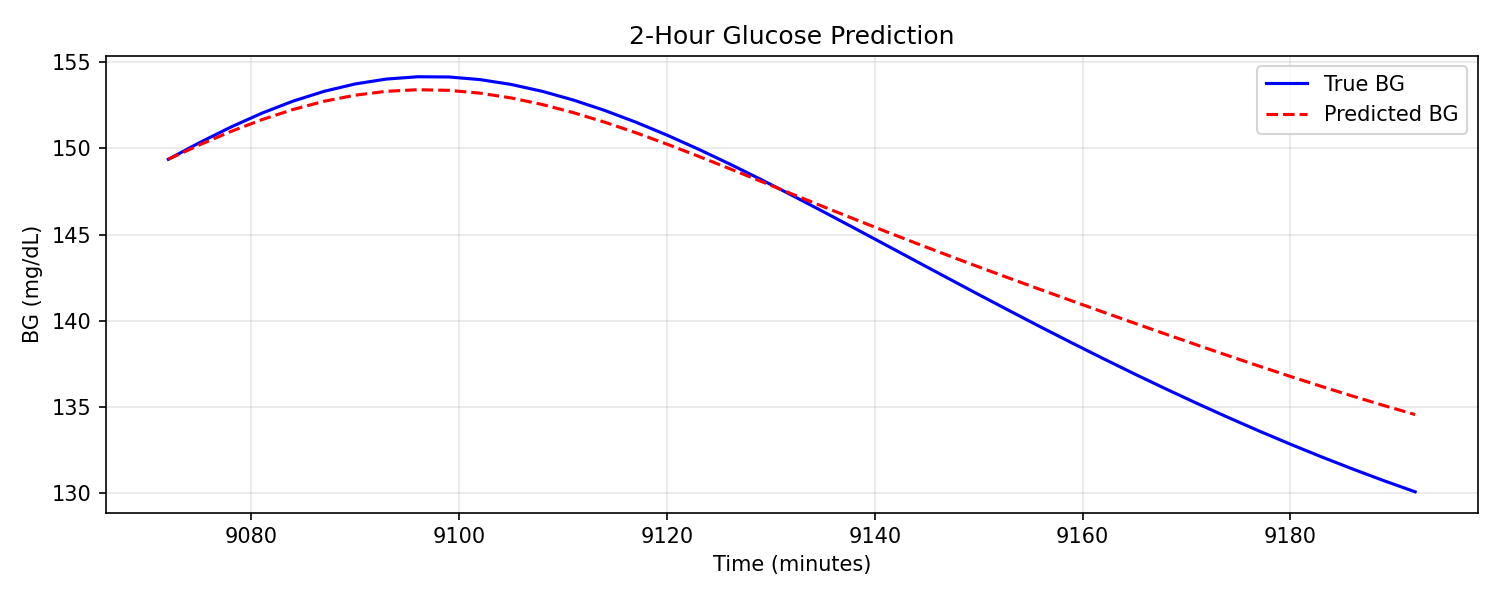

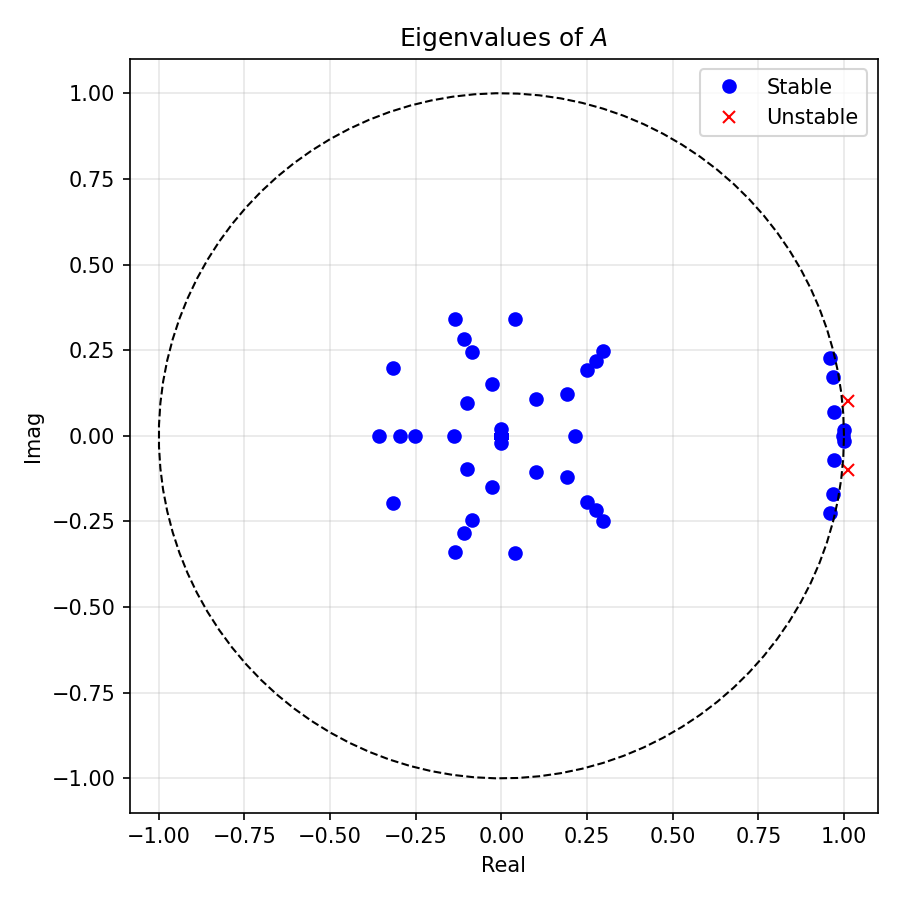

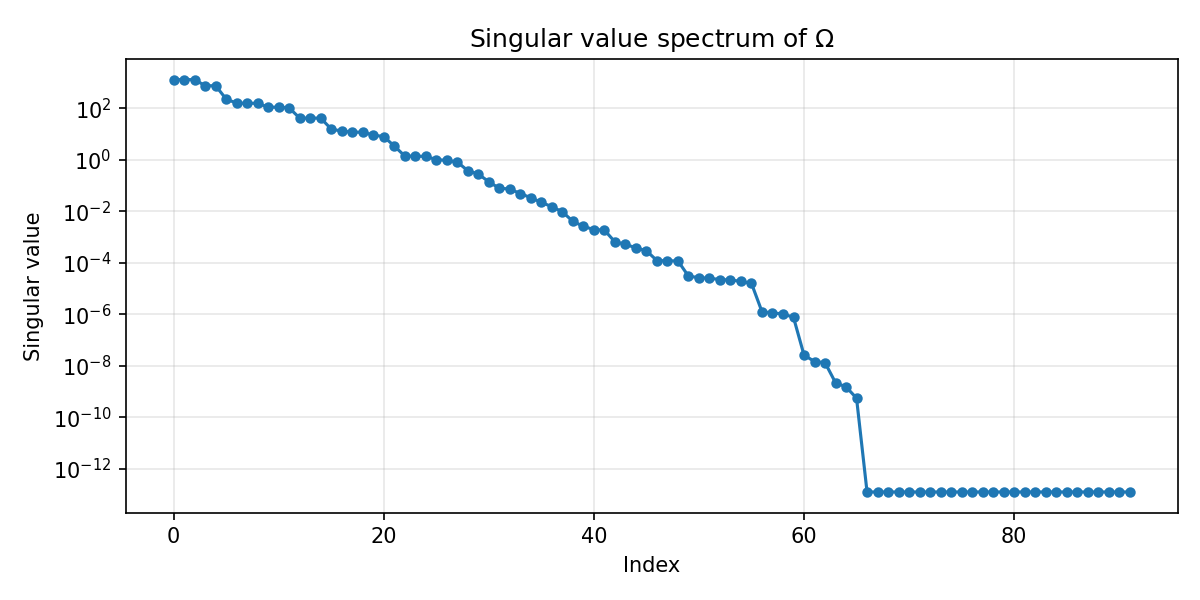

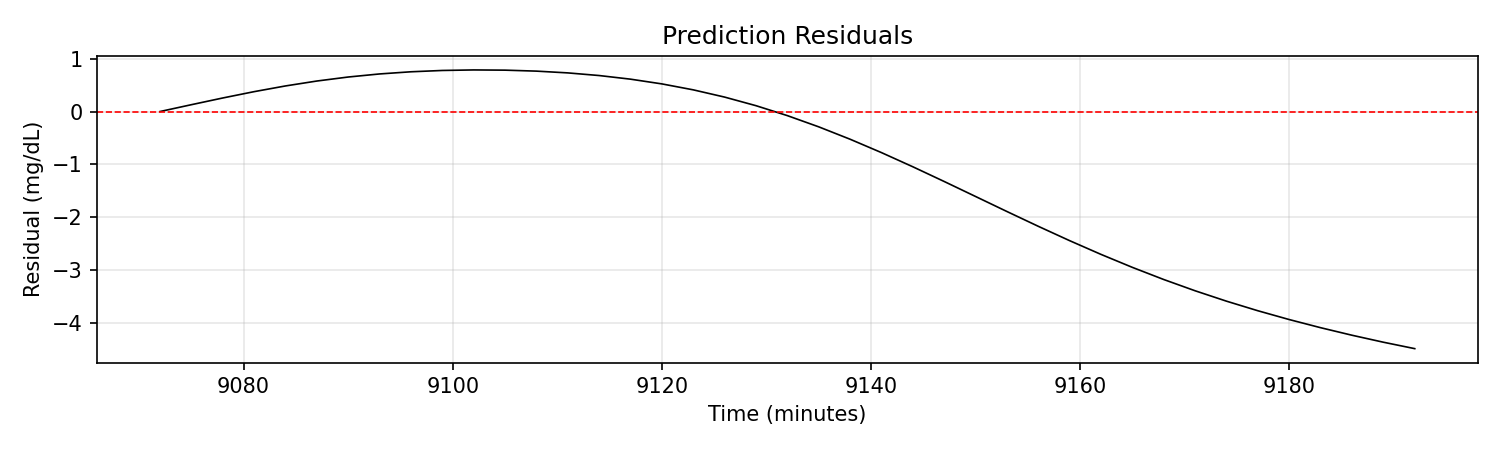

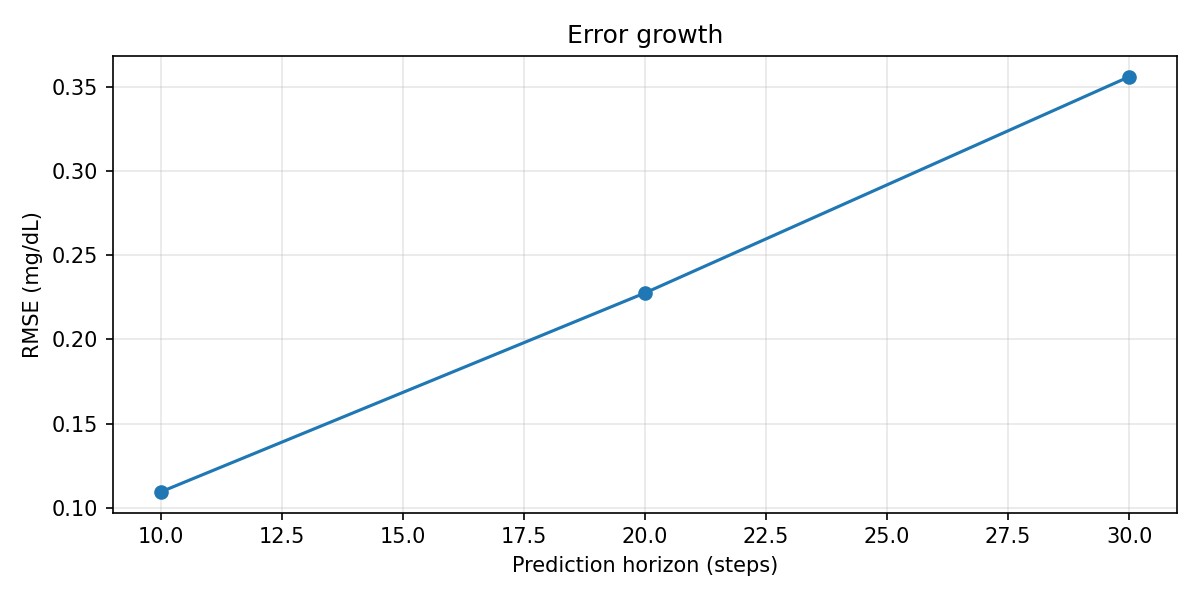

In [58]:
from IPython.display import Image, display
import os

results_dir = r"C:\Users\krish\Documents\Github\glycoSMC\glycoSMC\results"

files = [
    "adolescent_001_prediction.png",
    "adolescent_001_eigenvalues.png",
    "adolescent_001_singular_values.png",
    "adolescent_001_residuals.png",
    "adolescent_001_error_growth.png"
]

for f in files:
    path = os.path.join(results_dir, f)
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print("Not found:", path)
